In [1336]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import statsmodels.api as sm
import json
from statsmodels.stats.anova import anova_lm
from scipy.stats import ttest_ind

from typing import List,Dict,Tuple,Union


In [1337]:
sat_df = pd.read_excel('cond_2_May20_Sat/Satisfaction_ratings/df_Sat_Overall_Cond_2.xlsx')
choice_df = pd.read_excel('cond_2_May20_Sat/Choice_ratings/df_Choice_Overall_Cond_2.xlsx')


sat_df_first_half = pd.read_excel('cond_2_May20_Sat/Satisfaction_ratings/first_half/df_Sat_Overall_Cond_2_first_half.xlsx')
choice_df_first_half = pd.read_excel('cond_2_May20_Sat/Choice_ratings/first_half/df_Choice_Overall_Cond_2_first_half.xlsx')


sat_df_second_half = pd.read_excel('cond_2_May20_Sat/Satisfaction_ratings/second_half/df_Sat_Overall_Cond_2_second_half.xlsx')
choice_df_second_half = pd.read_excel('cond_2_May20_Sat/Choice_ratings/second_half/df_Choice_Overall_Cond_2_second_half.xlsx')

game_decks = pd.read_excel('traj_cond2_last_20_games.xlsx')

In [1338]:
sat_df
choice_df['participant'].unique()

array(['Participant1', 'Participant2', 'Participant3', 'Participant4',
       'Participant5', 'Participant6', 'Participant7', 'Participant8',
       'Participant9', 'Participant10', 'Participant11', 'Participant12',
       'Participant13', 'Participant14', 'Participant15', 'Participant16',
       'Participant17', 'Participant18', 'Participant19', 'Participant20'],
      dtype=object)

### Calculate participant accuracy


In [1339]:

def catch_test(dataframe):
    success_rates = []
    filtered_dataframes = []

    for participant in dataframe['participant'].unique():
        # Filter dataframe for the current participant and make a copy
        participant_df = dataframe[dataframe['participant'] == participant].copy()

        # Calculate conditions
        condition_1 = (participant_df['card_1'] > 0) & (participant_df['card_2'] < 0) & (participant_df['click_catch'] == 0)
        condition_2 = (participant_df['card_1'] < 0) & (participant_df['card_2'] > 0) & (participant_df['click_catch'] == 1)
        condition_3 = (participant_df['card_1'] > 0) & (participant_df['card_2'] > 0) & (participant_df['click_catch'] == 2)
        condition_4 = (participant_df['card_1'] < 0) & (participant_df['card_2'] < 0) & (participant_df['click_catch'] == 3)

        # Concatenate conditions using logical OR
        result_array = condition_1 | condition_2 | condition_3 | condition_4

        # Calculate success rate for the participant
        true_count = result_array.sum()
        success_rate = (true_count / len(participant_df)) * 100
        success_rates.append(success_rate)

        # Add success rates to the dataframe
        participant_df.loc[:, 'success_rate'] = success_rate

        # Exclude participants with success rate lower than 70%
        if success_rate >= 75:
            filtered_dataframes.append(participant_df)

    # Concatenate all filtered dataframes into a single dataframe
    filtered_dataframe = pd.concat(filtered_dataframes)

    return filtered_dataframe




In [1340]:
#Return filtered dataframe with only good participants

choice_filtered_df = catch_test(choice_df)
participants_to_keep = choice_filtered_df['participant'].unique()
print(len(participants_to_keep))

choice_filtered_df['participant'].unique()


# Filter the DataFrame to only include rows with the specified participants
sat_filtered_df = sat_df[sat_df['participant'].isin(participants_to_keep)].copy()

#Filter first half and second half dfs too

choice_filtered_df_first_half = choice_df_first_half[choice_df_first_half['participant'].isin(participants_to_keep)].copy()
choice_filtered_df_second_half = choice_df_second_half[choice_df_second_half['participant'].isin(participants_to_keep)].copy()

sat_filtered_df_first_half = sat_df_first_half[sat_df_first_half['participant'].isin(participants_to_keep)].copy()
sat_filtered_df_second_half = sat_df_second_half[sat_df_second_half['participant'].isin(participants_to_keep)].copy()



17


In [1341]:
#Check that satisfaction df and choice df have the same participants
sat_filtered_df['participant'].unique() == choice_filtered_df['participant'].unique()

sat_filtered_df_first_half['participant'].unique() == choice_filtered_df['participant'].unique()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [1342]:
def determine_outcome(df):
    # Initialize a list to store results
    results = []
    outcomes = []
    starting_points = []
    final_values = []

    # Group the dataframe by 'game_index' and 'participant'
    grouped_df = df.groupby(by=['participant', 'game_index', 'starting_point'])

    # Iterate over each group
    for name, group in grouped_df:
        # Get the amount at round 4 for the current group
        amount_at_round_4 = group.loc[group['round_number'] == 4, 'amount_calculation'].values
        
        outcome = -1 if amount_at_round_4 > 3 else 1
        
        # Assign the outcome to all rows in the current group
        group['game_outcome'] = outcome
        
        # Append the processed group to the results list
        results.append(group)
        
        # Append game outcomes
        outcomes.append(outcome)

        # Get starting points
        starting_point = group['starting_point'].values
        starting_points.append(starting_point)

        # Getting the ending value
        ending_value = group.loc[group["round_number"] == group["round_number"].max()]["amount_calculation"].values[0]
        final_values.append(ending_value)

    # Concatenate all groups back into a single dataframe
    result_df = pd.concat(results, ignore_index=True)

    return result_df, outcomes, starting_points, final_values


   

In [1343]:
choice_filtered_df, outcomes, part_starting_points, final_values = determine_outcome(choice_filtered_df)

choice_filtered_df_first_half, outcomes_first_half, part_starting_points_first_half, final_values_first_half = determine_outcome(choice_filtered_df_first_half)

choice_filtered_df_second_half, outcomes_second_half, part_starting_points_second_half, final_values_second_half = determine_outcome(choice_filtered_df_second_half)


In [1344]:
#create sublists to facilitate future use of outcomes and part_starting_points

number_participants = len(choice_df['participant'].unique())
outcomes_per_participant = []
part_starting_points_per_participant = []
final_values_per_participant = []

outcomes_per_participant_first_half = []
part_starting_points_per_participant_first_half = []
final_values_per_participant_first_half = []

outcomes_per_participant_second_half = []
part_starting_points_per_participant_second_half = []
final_values_per_participant_second_half = []

# Split outcomes into lists for each participant
for i in range(number_participants):
    start_index = i * 18
    end_index = (i + 1) * 18
    outcomes_per_participant.append(outcomes[start_index:end_index])
    part_starting_points_per_participant.append(part_starting_points[start_index:end_index])
    final_values_per_participant.append(final_values[start_index:end_index])


for i in range(number_participants):
    start_index = i * 9 #9 games of the first half
    end_index = (i + 1) * 9
    outcomes_per_participant_first_half.append(outcomes_first_half[start_index:end_index])
    part_starting_points_per_participant_first_half.append(part_starting_points_first_half[start_index:end_index])
    final_values_per_participant_first_half.append(final_values_first_half[start_index:end_index])


    outcomes_per_participant_second_half.append(outcomes_second_half[start_index:end_index])
    part_starting_points_per_participant_second_half.append(part_starting_points_second_half[start_index:end_index])
    final_values_per_participant_second_half.append(final_values_second_half[start_index:end_index])


In [1345]:
def generate_pair_sequences(choice_filtered_df:pd.DataFrame)->Dict[str,Dict[int,Tuple[int,int]]]:
    # Grouping by participant and game_index
    grouped_participants:pd.DataFrame.groupby = choice_filtered_df.groupby(by=['participant','game_index'])
    
    pair_sequences:Dict[str,Dict[int,List[int,int]]] = {}
    for participant_meta, participant_data in grouped_participants:
        # Extracting meta information to be used
        name:str = participant_meta[0] 
        game_number:int = participant_meta[1]
        #card_result:int = participant_meta[2]

        # If we haven't started recording data for that participant, add a dictionary
        if name not in pair_sequences.keys():
            pair_sequences[name] = {}

        # Ensuring that the data is sorted in the correct way
        participant_data.sort_values(by = "round_number",ascending=True,inplace=True)

        # Getting the card lists
        card_one_data:List[int] = participant_data["card_1"].to_list()
        card_two_data:List[int] = participant_data["card_2"].to_list()
        card_result_data:List[int] = participant_data["card_result"].to_list()
        
        # Creating the pair sequence but making sure the card_result is teh first card in the sequence
        game_pair_sequence: List[Tuple[int, int]] = [
            (card_result_data[i], card_two_data[i] if card_one_data[i] == card_result_data[i] else card_one_data[i])
            for i in range(len(card_one_data))
        ]

        # Adding the pair sequences to the dictionary
        pair_sequences[name][game_number] = game_pair_sequence

    return pair_sequences




In [1346]:
pair_sequences = generate_pair_sequences(choice_filtered_df)

pair_sequences_first_half = generate_pair_sequences(choice_filtered_df_first_half)

pair_sequences_second_half = generate_pair_sequences(choice_filtered_df_second_half)

#pair_sequences['Participant1']

In [1347]:
def map_decks(game_decks:pd.DataFrame)->Dict[int,List[int]]:
    # maps the index of the original dataframe to a column to store
    game_decks['position']= game_decks.index

    # choice a subset of data and make a copy
    subchoice:pd.DataFrame = game_decks[['position','Deck']].copy()

    # removing duplicate decks
    subchoice.drop_duplicates(subset='Deck',inplace=True)

    # sort again by position to keep the index order
    subchoice.sort_values(by='position',inplace=True, ascending=True)

    # since we know the index order has been preserved, we can now reset it 
    subchoice.reset_index(inplace=True,drop=True)

    # redefining into a column for zipping
    subchoice['position'] = subchoice.index

    # creating dict to store
    decks:Dict[int,List[int]] = {}
    for index,deck in zip(subchoice['position'],subchoice['Deck']):
        # the deck is saved as a string, so need to split on commas and convert to an int
        deck_string:List[str] = deck.split(',')
        deck_final:List[int] = [int(card.strip()) for card in deck_string]
        decks[index] = deck_final
    return decks

In [1348]:
decks = map_decks(game_decks)


In [1349]:

def create_dict(pair_sequences, decks, outcomes_per_participant, part_starting_points_per_participant, final_values_per_participant):
    game_dicts = {}
    pair_var = []
    pair_ev = []
    participant_idx = 0 


    
    for participant in pair_sequences:
        
        for game in pair_sequences[participant]:
            nmax = 5
            deck = decks[game]
            pair_seq = pair_sequences[participant][game]

            for pair in pair_seq:
                var = np.var(pair)
                ev = np.mean(pair)
                pair_var.append(var)
                pair_ev.append(ev)


            #add game outcome and starting point
            is_win = outcomes_per_participant[participant_idx][game]
            starting_point = part_starting_points_per_participant[participant_idx][game][0]
            final_value = final_values_per_participant[participant_idx][game]
            

            thegame = {
                'ublb': [3, -100],
                'nmax': nmax,
                'deck': np.array(deck),
                'isbust': False,
                'pairseq': np.array(pair_seq),
                'iswin': is_win,
                'starting_point': starting_point,
                'pair_var': pair_var,
                'pair_ev': pair_ev,
                'final_value':final_value,
            }


            #re-initialise pair_ev and pair_var
            pair_var = []
            pair_ev = []
            

            # Store the game dictionary in the results with appropriate keys
            game_dicts[(participant, game)] = thegame

        participant_idx = participant_idx+1


    return game_dicts


In [1350]:
game_dicts = create_dict(pair_sequences, decks, outcomes_per_participant, part_starting_points_per_participant, final_values_per_participant)



In [1351]:

def create_dict_2(pair_sequences, decks, outcomes_per_participant, part_starting_points_per_participant, final_values_per_participant):
    game_dicts = {}
    pair_var = []
    pair_ev = []
    participant_idx = 0 
    game_index = range(0,9)


    
    for participant in pair_sequences:
        
        for game, iter in zip(pair_sequences[participant], game_index):
            nmax = 5
            deck = decks[game]
            pair_seq = pair_sequences[participant][game]

            for pair in pair_seq:
                var = np.var(pair)
                ev = np.mean(pair)
                pair_var.append(var)
                pair_ev.append(ev)


            #add game outcome and starting point
            is_win = outcomes_per_participant[participant_idx][iter]
            starting_point = part_starting_points_per_participant[participant_idx][iter][0]
            final_value = final_values_per_participant[participant_idx][iter]
            

            thegame = {
                'ublb': [3, -100],
                'nmax': nmax,
                'deck': np.array(deck),
                'isbust': False,
                'pairseq': np.array(pair_seq),
                'iswin': is_win,
                'starting_point': starting_point,
                'pair_var': pair_var,
                'pair_ev': pair_ev,
                'final_value':final_value,
            }


            #re-initialise pair_ev and pair_var
            pair_var = []
            pair_ev = []
            

            # Store the game dictionary in the results with appropriate keys
            game_dicts[(participant, game)] = thegame

        participant_idx = participant_idx+1


    return game_dicts


In [1352]:
len(range(0,10))

10

In [1353]:
game_dicts_first_half = create_dict_2(pair_sequences_first_half, decks, outcomes_per_participant_first_half, part_starting_points_per_participant_first_half, final_values_per_participant_first_half)
game_dicts_second_half = create_dict_2(pair_sequences_second_half, decks, outcomes_per_participant_second_half, part_starting_points_per_participant_second_half, final_values_per_participant_second_half)

In [1354]:
#create a function that generates a list of probability distributions representing
#the sum of card values for different numbers of cards at hand in a card game

def gen_distribution(thegame):

    #retrieve maximum number of rounds from game
    max_rounds = thegame ['nmax'] 

    starting_point = thegame['starting_point']

    #calculate unique card values ('xs') and their corresponding counts in the deck
    unique_cards, card_counts = np.unique(thegame['deck'], return_counts = True)

    #compute probability distribution of card values based on their counts in the deck
    probability_of_card = card_counts / sum(card_counts)

    #initialise a pandas Series representing the probability diustribution of card values
    card_probability_list = [pd.Series(probability_of_card, index=unique_cards)]

    #initiate a loop to calculate probability distributions for different numbers of cards at hand.
    # we start the loop on round two
    for round_number in range (2, max_rounds +1):

        #generate an array of possible sum values ('sums') based on the minimum and maximum card values in the deck
        #adapt sum depending on starting point

        # The minimum hand at round n is the lowest number n times, max is the reverse
        sums = np.arange(min(unique_cards)*round_number, max(unique_cards)*round_number + 1)

        # Adding in the starting point to represent an initial value
        sums += starting_point

        #initialise a panda Series filled with zeros and indexed by possible sum values
        probability_of_summing_to_value = pd.Series(np.zeros(len(sums)), index=sums) 
       
        #retrieve the probability distribution ('psum0') from the list ('allpsum') for the previous number of cards at hand
        # we subtract two so that we can convert round number to an index that starts at zero
        probabilities_from_previous_hand = card_probability_list[round_number - 2]

        #initiate a loop over the unique card values ('xs') with their corresponding indices ('kx')
        for position, card_value in enumerate(unique_cards):

            #initiate a nested loop over the indices of the previous probability distribution ('psum0')
            for prior_card in probabilities_from_previous_hand.index.values:

                #update the current probability distribution ('psum') by adding the product of the probability of the previous
                #sum ('psum0[x0]'), the probability of the current card value ('ps[kx]), and the current card value ('x')
                
                # Picking out the probability of the prior card
                probability_of_prior_card = probabilities_from_previous_hand[prior_card]
                probability_of_current_card = probability_of_card[position]
                
                # sum value
                new_sum = card_value + prior_card 

                # Since the prior_card value has built in the starting point, adding again
                # will diverge us from the true value.
                if round_number == 2:
                    new_sum += starting_point
                
                probability_of_summing_to_value[new_sum] += probability_of_prior_card * probability_of_current_card
                
        #append the calculated probabilioty distribution for the current number of cards at hand to the list ('allpsum')       
        card_probability_list.append(probability_of_summing_to_value)
    
    #return the list containing the probability distributions for different numbers of cards at hand
    return card_probability_list

In [1355]:
#Create a function to evaluate the current state of the game and determine if a player
#has won, lost or if the outcome is still unknown based on the game parameters and the sum
#of cards drawn so far

#cs: list representing the current state of the game (contains sum of card values drawn so far)
#thegame: a dictionary contianing information about the game, sucas upper and lower bounds for winning
#wether busting is allowed, and the maximum of cards allowed.
def dowin(cs,thegame):

    #extract the game parameters upper and lower bounds for winning
    ub,lb = thegame['ublb']

    #calculate whether the current game state is 'bad' by checking if the sum of card values (sum(cs))
    #exceeds the upper bound (ub) or falls below the lower bound (lb)
    #If either condition is true, 'badnow' is set to 'True'
    badnow =(sum(cs)>=ub) or (sum(cs)<=lb)
    
    outcome=0 #initialise outcome to 0 to indicate unknown outcome
    
    #if the currrent state is 'bad', check if busting is allowed (isbust) or not (not thegame['isbust']) 
    #and the maximum number of cards (len(cs)) has been drawn. If either condition is true, it means the 
    #player has lost and the outcome is set to -1.
    if badnow:
        if thegame['isbust'] or (not thegame['isbust'] and len(cs)==thegame['nmax']):
            outcome=-1 #lost

    #if the current state is not 'bad', check if the maximum number of cards allowed (nmax) has been drawn. 
    #If true, it means the player has reached the end without busting and outcome is set to 1, indicating a win.
    else:
        if len(cs)==thegame['nmax']: #already reaching the end without death
            outcome=1 #win
    return outcome


In [1356]:
#Create function to calculate the probability to win at each stage of drawing cards in the game
#considering deck composition, upper and lower bounds for winning, and whether busting is allowed
#returns the resulting probabilities in allpwin

def gen_pwin(thegame):

    #retrive maximum number of cards allowed, ub, lb, and whether busting is allowed
    max_rounds=thegame['nmax']
    ub,lb = thegame['ublb']
    isbust = thegame['isbust']

    starting_value = thegame["starting_point"]

    #Calculate card probabilities:
    #Calculate the unique card values (xs) and their corresponding counts in the deck 
    deck,card_count = np.unique(thegame['deck'],return_counts=True)

    #compute the probability distribution of card values (ps) based on their counts in the deck
    ps = card_count/sum(card_count)

    # if thegame["final_value"] == -64:
    #     b  = 1

    #generate probability distribution for card sums. 
    allpsum = gen_distribution(thegame)

    #initialise probability table for winning:
    #initialise a list (allpwin) to store the probability of winning at each stage of drawing cards
    #each element corresponds to the probability distribution after drawing a certain number of additional cards (kk)
    allpwin=[[] for kk in range(max_rounds+1)] # after drawing kk'th card, 
    
    #Calculate initial winning probabilities:
    

    #generate an array of possible sum values (sums) based on the min and max card values in the deck multiplied by the number of cards (N)
    sums = np.arange(min(deck)*max_rounds,max(deck)*max_rounds + 1) + starting_value

    #compute the initial prob of winning (pwin) for each possible sum value
    #sets the prob to 1 if the sum falls within the winning bounds (ub and lb), otherwise to 0
    pwin = [int(k<ub and k>lb) for k in sums] # p can only be 0 or 1
    
    #store initial pwin prob in allpwin[0]
    allpwin[0]=pd.Series(pwin,index=sums) 
    
        
    #Calculate winning prob for further points: now start recursive calc
    
    #iterate through the number of additional cards to be drawn (nmore) from 1 to nmax
    #for each nmore, calculate the probability of winning pwin for each possible sum value (sums) based on game state
    for additional_cards in range(1,max_rounds+1): #how many more cards to be drawn at most
        
        round_backwards = max_rounds-additional_cards
        sums = np.arange(min(deck)*round_backwards -10,max(deck)*round_backwards+1) + starting_value #all possible sum values at this point
        pwin=[]
        for s in sums:

            #if busting is allowed, calculate the prob recursiverly considering the prob of previous states (allpwin[nmore-1])
            if isbust:
                if s>=ub or s<=lb: # bust here!
                    pwin.append(0) #if a bust occurs, pwin is set to 0, indicating a loss
                    continue #skips the remaining code within the loop and moves to next iteration
                
                #if a bust has not occured:
                else:    
                    pw=0

                    # Compute the probability of winning for each possible next card value:
                    # Computes the probability of winning (ps[kx] * allpwin[nmore - 1][s + xnext]) 
                    # for each possible next card value (xnext). It multiplies the probability of 
                    # drawing card value xnext (ps[kx]) with the probability of winning in the previous 
                    # state (allpwin[nmore - 1][s + xnext]) and accumulates the results in pw
                    for kx,xnext in enumerate(deck):
                        pw += ps[kx] * allpwin[additional_cards-1][s+xnext]                    
                    pwin.append(pw)
            
            #if busting is not allowed, calculate the prob based on precomputed prob distributions (allpsum) for all remaining cards
            else:
                psum = allpsum[additional_cards-1] # probability of the sum of ALL the remaining cards
                thisp = max(min(sum([psum[smr] for smr in psum.index.values if s+smr<ub and s+smr>lb]),1),0)
                pwin.append(thisp)
        
        #After iterating over all possible sum values, it stores the computed probabilities of winning (pwin) in 
        #the allpwin list at index nmore. Each entry in allpwin represents the probability distribution of winning 
        #after drawing a certain number of additional cards (nmore).
        allpwin[additional_cards]=pd.Series(pwin,index=sums)
    
    #set thegame[allpwin] to the computed list of winning probabilities allpwin
    thegame['allpwin'] = allpwin #round to avoid precision err
    return  #note, allpwin is indexed by nmore, not how many cards at hand


In [1357]:
#Function to calculate the suspense associated with choosing two cards based on L1 norm

#cpair is a tuple containg two card values representing the 2 cards being considered
#cpast is a list representing cards drawn previously
#thegame is a dictionary containing info about game stata and pre-calculated probabilities of winning at each stage (allpwin)
def L1_susp(cpair,cpast,mod,thegame):
    
    #assign a string L1 to the variable 'mod'
    mod = 'L1'
    starting_value = thegame["starting_point"]

    #retrieve pre-calculated prob of winning
    allpwin = thegame['allpwin']

    #calculate the number of additional cards to be drawn based on the max number of cards allowed and cards drawn so far
    nmore = thegame['nmax'] - len(cpast)

    #compute the sum of card values drawn in previous rounds
    snow = sum(cpast)

    #Retrieve probability of winning associated with the sum of card values for the first card in the pair
    try:
        p0=allpwin[nmore-1][snow+cpair[0]+starting_value]
    except Exception as e:
        print(f"P0 Index for final value: {thegame['final_value']}")
        p0 = 1

    #Retrieve probability of winning associated with the sum of card values for the second card in the pair
    try:
        p1=allpwin[nmore-1][snow+cpair[1]+starting_value]
    except Exception as e:
        print(f"P1 Index for final value: {thegame['final_value']}")
        p1 = 1

    #Calculate suspense by computing the absolute difference between the prob of winning for the two cards in the pair cpair
    #The difference reprrsents the suspense associated with choosing between the two cards
    susp = np.abs(p0 - p1)

    if nmore == 1:
        if susp == 1:
            b = 1

    return susp

In [1358]:

#cpair is a tuple containg two card values representing the 2 cards being considered
#cpast is a list representing cards drawn previously
#thegame is a dictionary containing info about game stata and pre-calculated probabilities of winning at each stage (allpwin)
def prob_win_1(cpair,cpast,thegame):
    
    
    #retrieve pre-calculated prob of winning
    allpwin = thegame['allpwin']
    starting_value = thegame["starting_point"]

    #calculate the number of additional cards to be drawn based on the max number of cards allowed and cards drawn so far
    nmore = thegame['nmax'] - len(cpast)

    #compute the sum of card values drawn in previous rounds
    snow = sum(cpast)

    #Retrieve probability of winning associated with the sum of card values for the first card in the pair
    try:
        p_card_1=allpwin[nmore-1][snow+cpair[0]+starting_value]
    except Exception as e:
        print(f"Failed getting probability for final count: {thegame['final_value']}")
        p_card_1 = 1

    rounds = np.array([1, 2, 3, 4, 5])


    prob_win_1 = (p_card_1-0.5)

    return prob_win_1

In [1359]:
#Compute suspense values for different models for each pair

#default model to use is L1
def suscompute(thegame,susmods = ['L1']):
    #given the selected sequences, what are the sus
    #output stored in "thegame"

    #if allpwin key is not present in thegame dictionary, compute the prob of winning for
    #different game states using the gen_pwin function which retrieves the pair 
    if 'allpwin' not in thegame:
        gen_pwin(thegame)
    pairs = thegame['pairseq']
    
    #initialise empty dictionary to store the suspense values for each model
    suscpr = {} # dictionary

    #iterate through each model in susmods
    for m in susmods:

        #initialise empty list for each model in suscpr, where each list will contain the suspense values for each pair in the sequence
        #the length of each list will be the same as the length of the pair sequence.
        suscpr[m]=[[] for k in range(len(pairs))]

    #iterate through pairs
    for n in range(len(pairs)): # how many pairs before finally done
        
        #calculate the remaining number of pairs before game ends
        nmore = thegame['nmax']-n

        #retrieve current pair from the pair sequence
        pair = pairs[n]   

        #iterate through each model specified in susmods                             
        for mod in susmods:

            #compute the suspense value of the current pair, using L1_susp for the specified model ('mod')
            #it considers the first card in all previously drawn pairs (pairs[:n,0]) and passes the game state
            #thegame as an argument
            #this process populates suscpr with suspense values for each model and each pair in the pair sequence
            suscpr[mod][n]=L1_susp(pair,pairs[:n,0],mod,thegame)                    
    
    #update game state with the computed suspense values stored in suspcr
    thegame['suscpr']=suscpr
    return

In [1360]:

def prob_1_compute(thegame):
    #given the selected sequences, what are the sus
    #output stored in "thegame"

    #if allpwin key is not present in thegame dictionary, compute the prob of winning for
    #different game states using the gen_pwin function which retrieves the pair 
    if 'allpwin' not in thegame:
        gen_pwin(thegame)
    pairs = thegame['pairseq']
    
    #initialise empty dictionary to store the suspense values for each model
    prob_win = {} # dictionary

    #iterate through pairs
    for pair_number in range(len(pairs)): # how many pairs before finally done
        
        #calculate the remaining number of pairs before game ends
        nmore = thegame['nmax']-pair_number

        #retrieve current pair from the pair sequence
        pair = pairs[pair_number]   

        #iterate through each model specified in susmods                             
 
        prob_win[pair_number]=prob_win_1(pair,pairs[:pair_number,0],thegame) 

    #update game state with the computed suspense values stored in suspcr
    thegame['prob_win_1']=prob_win
    #thegame['d_prob_win_1'] = np.diff(prob_win)
    return

In [1361]:
# Compute suspense values for each game for each participant

for participants in game_dicts:
    for game in participants:
        

        thegame = game_dicts[participants]
        if thegame["isbust"]:
            print("Exists bust game")

        suscompute(thegame,['L1'])
        prob_1_compute(thegame)



for participants in game_dicts_first_half:
    for game in participants:
        

        thegame = game_dicts_first_half[participants]
        if thegame["isbust"]:
            print("Exists bust game")

        suscompute(thegame,['L1'])
        prob_1_compute(thegame)


for participants in game_dicts_second_half:
    for game in participants:
        

        thegame = game_dicts_second_half[participants]
        if thegame["isbust"]:
            print("Exists bust game")

        suscompute(thegame,['L1'])
        prob_1_compute(thegame)




In [1362]:
def plotsusmod(game):
    x = range(5)
    y = game['suscpr']['L1']

    plt.plot(x, y, '--o', label='L1')
    plt.ylabel('suspense')
    plt.xlabel('index')
    plt.ylim(0, 1.2)  # Set y-axis limits if needed
    plt.legend()

    pairs = game['pairseq']
    cards = [p[0] for p in pairs]
    xtick_labels = [[list(np.cumsum(cards) - cards)[k] + game["starting_point"], list(pairs[k])] for k in range(len(pairs))]

    plt.xticks(np.arange(len(y)), xtick_labels, rotation=45, ha='right')
    plt.xlabel('current sum, next pair')

    bust = ['Total', 'Bust']
    tittx = 'rule: ' + bust[game['isbust']] + ', ' + str(game['ublb'])
    plt.title(tittx)





In [1363]:
game_dicts['Participant1', 0]['suscpr']

{'L1': [0.17344916933394294,
  0.08916323731138542,
  0.03703703703703709,
  0.05555555555555558,
  0]}

In [1364]:

#for participants in game_dicts:
    # Plot the graph for the current game
    #for game in participants:
     #  thegame = game_dicts[participants]
       #plotsusmod(thegame)
    #plt.show()

In [1365]:
average_susp_all_participants = []

for participant in game_dicts:
    #Get average suspense across all games
    avg_suspense = np.mean(game_dicts[participant]['suscpr']['L1'])

    average_susp_all_participants.append(avg_suspense)

In [1366]:
import itertools


Pairwise t-tests:
Participant 1 vs Participant 2:
  t-statistic = 0.2054, p-value = 0.8385
Participant 1 vs Participant 3:
  t-statistic = 0.8613, p-value = 0.3951
Participant 1 vs Participant 4:
  t-statistic = 0.1875, p-value = 0.8524
Participant 1 vs Participant 5:
  t-statistic = 0.4727, p-value = 0.6395
Participant 1 vs Participant 6:
  t-statistic = -1.7761, p-value = 0.0847
Participant 1 vs Participant 7:
  t-statistic = 1.1000, p-value = 0.2790
Participant 1 vs Participant 8:
  t-statistic = 1.0949, p-value = 0.2813
Participant 1 vs Participant 9:
  t-statistic = 1.5147, p-value = 0.1391
Participant 1 vs Participant 10:
  t-statistic = 0.2966, p-value = 0.7686
Participant 1 vs Participant 11:
  t-statistic = 2.4028, p-value = 0.0219
Participant 1 vs Participant 12:
  t-statistic = -0.8755, p-value = 0.3875
Participant 1 vs Participant 13:
  t-statistic = 2.0386, p-value = 0.0493
Participant 1 vs Participant 14:
  t-statistic = 1.3619, p-value = 0.1822
Participant 1 vs Participa

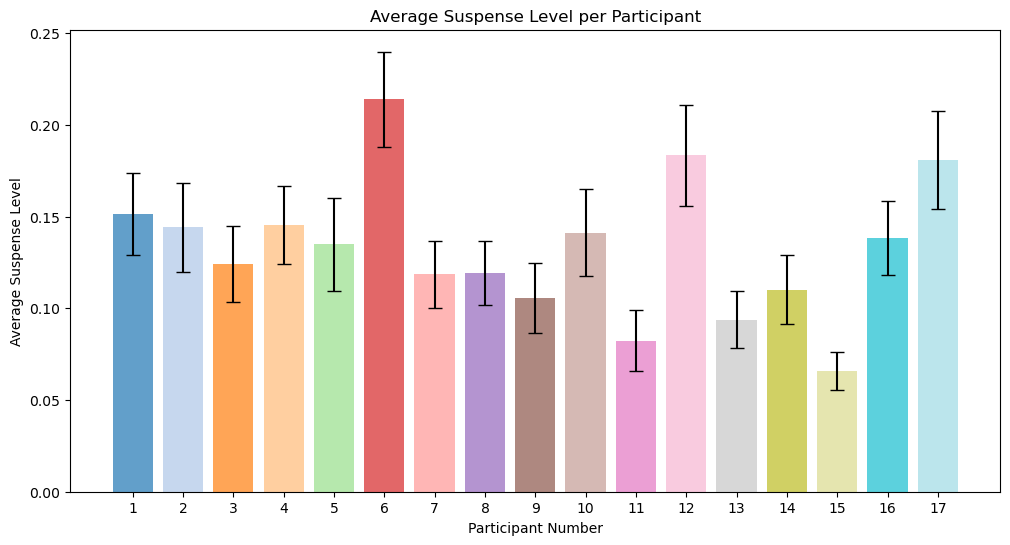

In [1367]:

# Number of games per participant
number_of_games = 18

# Calculate the number of participants
number_of_participants = len(average_susp_all_participants) // number_of_games

# Initialize lists to store the average suspense level and standard error for each participant
average_suspense_per_participant = []
standard_error_per_participant = []
participant_data_list = []

# Calculate the average suspense level and standard error for each participant
for i in range(number_of_participants):
    start_index = i * number_of_games
    end_index = start_index + number_of_games
    participant_data = average_susp_all_participants[start_index:end_index]
    average_suspense = np.mean(participant_data)
    standard_error = np.std(participant_data) / np.sqrt(number_of_games)
    
    average_suspense_per_participant.append(average_suspense)
    standard_error_per_participant.append(standard_error)
    participant_data_list.append(participant_data)

# Generate a list of unique colors for each participant
colors = plt.cm.tab20(np.linspace(0, 1, number_of_participants))

# Plotting the data
plt.figure(figsize=(12, 6))
bars = plt.bar(range(1, number_of_participants + 1), average_suspense_per_participant, yerr=standard_error_per_participant, capsize=5, color=colors, alpha=0.7)
plt.xlabel('Participant Number')
plt.ylabel('Average Suspense Level')
plt.title('Average Suspense Level per Participant')
plt.xticks(range(1, number_of_participants + 1))

# Perform pairwise t-tests and print the results
print("Pairwise t-tests:")
for (i, j) in itertools.combinations(range(number_of_participants), 2):
    t_stat, p_value = ttest_ind(participant_data_list[i], participant_data_list[j])
    print(f'Participant {i+1} vs Participant {j+1}:\n  t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}')

plt.show()


### Simulate participant behaviour if they had chosen only low EV

In [1368]:
#get card choices shown to each participant

game_decks

# Remove the last 10 rows and create a copy
game_decks = game_decks.iloc[:-10].copy()

# Drop the 'Experiment' column
game_decks.drop(columns=['Experiment'], inplace=True)


In [1369]:

def add_pair_options_to_dict(game_decks):
    # Initialize an empty list to store pair options for each game
    pair_options_list = []
    sim_dict = {}

    # Iterate over each group of 5 rows (representing a game round)
    for i in range(0, len(game_decks), 5):
        # Extract the pairs of options for this game round
        pair_options = game_decks.iloc[i:i+5][['Pair 1', 'Pair 2', 'Pair 3', 'Pair 4', 'Pair 5', 'Pair 6']].values.tolist()

        # Convert the elements of pair options from strings to integers
        subarrays_of_6 = [[int(val) for val in pair.split(',')] for round_pairs in pair_options for pair in round_pairs]

        # Reshape each game's pair options so that each subarray contains pairs from a single round of the game
        subarrays_of_6 = [subarrays_of_6[j:j+6] for j in range(0, len(subarrays_of_6), 6)]

        # Append the pair options to the list
        pair_options_list.append(subarrays_of_6)

    # Assign the reshaped pair options to sim_dict
    sim_dict['pair_options'] = pair_options_list

    return sim_dict



In [1370]:
sim_dict= add_pair_options_to_dict(game_decks)

In [1371]:
def calculate_small_EV(sim_dict):
    small_EV = []
    small_EV_per_round = []
    small_EV_pair_per_round = []


    for game_rounds in sim_dict['pair_options']:
        for round_pairs in game_rounds:
            min_EV = float('inf')  # Initialize with positive infinity
            for pairs in round_pairs:
                # Calculate the expected value for the pair 
                EV = sum(pairs) / len(pairs)

                if EV < min_EV:
                    min_EV = EV
                    min_EV_pair = pairs

            small_EV = min_EV
            small_EV_pair = min_EV_pair
                
            small_EV_per_round.append(small_EV)
            small_EV_pair_per_round.append(small_EV_pair)

    #reshape to get an 18 games 5 rounds array
    small_EV_per_round = np.array(small_EV_per_round)
    small_EV_per_round = small_EV_per_round.reshape(18, 5, -1)

    small_EV_pair_per_round = np.array(small_EV_pair_per_round)
    small_EV_pair_per_round = small_EV_pair_per_round.reshape(18, 5, -1)
    

    # Assign the reshaped pair options to sim_dict
    sim_dict['pair_min_EV'] = small_EV_per_round

    # Assign the reshaped pair options to sim_dict
    sim_dict['pair_min_EV_cards'] = small_EV_pair_per_round



    return sim_dict

In [1372]:
def calculate_small_Var(sim_dict):
    small_Var = []
    small_Var_per_round = []
    small_Var_pair_per_round = []

    for game_rounds in sim_dict['pair_options']:
        for round_pairs in game_rounds:
            min_Var = float('inf')  # Initialize with positive infinity

            for pairs in round_pairs:
                # Calculate the expected value for the pair (for demonstration, let's assume some calculation)
                # Here you can replace this line with your actual calculation for expected value
                Var = np.var(pairs)

                if Var < min_Var:
                    min_Var = Var
                    min_Var_pair = pairs

            small_Var = min_Var
            small_Var_pair = min_Var_pair
            small_Var_per_round.append(small_Var)
            small_Var_pair_per_round.append(small_Var_pair)

    #reshape to get an 18 games 5 rounds array
    small_Var_per_round = np.array(small_Var_per_round)
    small_Var_per_round = small_Var_per_round.reshape(18, 5, -1)

    small_Var_pair_per_round = np.array(small_Var_pair_per_round)
    small_Var_pair_per_round = small_Var_pair_per_round.reshape(18, 5, -1)
    

    # Assign the reshaped pair options to sim_dict
    sim_dict['pair_min_Var'] = small_Var_per_round
    sim_dict['pair_min_Var_cards'] = small_Var_pair_per_round


    return sim_dict

In [1373]:

def calculate_small_EV_Var(sim_dict):

    small_EV_Var_per_round = []
    small_EV_Var_pair_per_round = []

    min_EV = float('inf')  # Initialize with positive infinity
    min_Var = float('inf')  # Initialize with positive infinity

    for game_rounds in sim_dict['pair_options']:
        for round_pairs in game_rounds:
            min_EV = float('inf')  # Initialize with positive infinity
            min_Var = float('inf')  # Initialize with positive infinity
            for pairs in round_pairs:
                # Calculate the expected value for the pair
                EV = sum(pairs) / len(pairs)
                # Calculate the variance for the pair
                Var = np.var(pairs)

                # If both EV and Var are smaller than the current minimum, update
                if EV < min_EV and Var < min_Var:
                    min_EV = EV
                    min_Var = Var
                    pair = pairs

            # After iterating through all pairs for this round, append the smallest EV and Var
            small_EV_Var_per_round.append((min_EV, min_Var))
            small_EV_Var_pair_per_round.append((pair))
      

    # Reshape to get an 18 games 5 rounds array
    small_EV_Var_per_round = np.array(small_EV_Var_per_round).reshape(18, 5, -1)
    small_EV_Var_pair_per_round = np.array(small_EV_Var_pair_per_round).reshape(18, 5, -1)


    # Assign the reshaped pair options to sim_dict
    sim_dict['pair_min_EV_Var'] = small_EV_Var_per_round
    sim_dict['pair_min_EV_Var_cards'] = small_EV_Var_pair_per_round

    return sim_dict

In [1374]:
#Returns simulation deck with the smallest EV
sim_dict = calculate_small_EV(sim_dict)
sim_dict = calculate_small_Var(sim_dict)
sim_dict = calculate_small_EV_Var(sim_dict)



In [1375]:
sim_dict['pair_min_EV_Var_cards']

array([[[ -2, -10],
        [ -3, -10],
        [ -2, -11],
        [-10,  -1],
        [-11,  -1]],

       [[-10,  -4],
        [-11,  -3],
        [-11,  -6],
        [-11,  -3],
        [ -2, -10]],

       [[-10,  -5],
        [ -3,  -6],
        [-11,  -3],
        [-11,  -6],
        [-11,  -2]],

       [[ -3,  -8],
        [ -3, -10],
        [ -3, -10],
        [ -3,  -8],
        [-11,  -1]],

       [[ -4,  -9],
        [ -4, -10],
        [ -4,  -9],
        [-10,  -2],
        [ -1, -10]],

       [[ -8,  -3],
        [-11,  -1],
        [-10,  -3],
        [-11,  -2],
        [-11,  -2]],

       [[-11,  -5],
        [-11,  -2],
        [-11,  -3],
        [-11,   0],
        [ -4,  -9]],

       [[-11,   0],
        [ -1, -10],
        [-11,  -5],
        [-11,  -5],
        [-11,  -2]],

       [[-10,  -4],
        [-10,  -4],
        [ -3, -10],
        [-11,  -4],
        [ -9,  -2]],

       [[ -3, -10],
        [ -8,  -3],
        [ -2, -10],
        [ -8,  -3],
  

In [1376]:
def compute_avg_counts_ev(sim_dict, starting_point, num_participants=20):
    pair_min_EV_cards = sim_dict['pair_min_EV_cards']
    num_rounds = len(pair_min_EV_cards[0])
    
    all_game_averages = []

    for game in pair_min_EV_cards:
        participant_sums = np.zeros((num_participants, num_rounds))

        for participant in range(num_participants):
            cumulative_sum = starting_point
            for round_idx, round in enumerate(game):
                selected_card = np.random.choice(round)
                cumulative_sum += selected_card
                participant_sums[participant, round_idx] = cumulative_sum
        
        
        
        average_counts = participant_sums.mean(axis=0)
        all_game_averages.append(average_counts)
    
    all_game_averages = np.array(all_game_averages)
    overall_averages = all_game_averages.mean(axis=0)
    overall_std = all_game_averages.std(axis=0)
    overall_se = overall_std / np.sqrt(len(pair_min_EV_cards))
    
    return np.array(overall_averages), np.array(overall_se)



    


In [1377]:
average_min_EV_count_0, std_err_min_EV_count_0 = compute_avg_counts_ev(sim_dict, starting_point = 0)
average_min_EV_count_10, std_err_min_EV_count_10 = compute_avg_counts_ev(sim_dict, starting_point = 10)
average_min_EV_count_minus_10, std_err_min_EV_count_minus_10 = compute_avg_counts_ev(sim_dict, starting_point = -10)


In [1378]:
def compute_avg_counts_var(sim_dict, starting_point, num_participants=20):
    pair_min_Var_cards = sim_dict['pair_min_Var_cards']
    num_rounds = len(pair_min_Var_cards[0])
    
    all_game_averages = []

    for game in pair_min_Var_cards:
        participant_sums = np.zeros((num_participants, num_rounds))

        for participant in range(num_participants):
            cumulative_sum = starting_point
            for round_idx, round in enumerate(game):
                selected_card = np.random.choice(round)
                cumulative_sum += selected_card
                participant_sums[participant, round_idx] = cumulative_sum
        
        average_counts = participant_sums.mean(axis=0)
        all_game_averages.append(average_counts)
    
    all_game_averages = np.array(all_game_averages)
    overall_averages = all_game_averages.mean(axis=0)
    overall_std = all_game_averages.std(axis=0)
    overall_se = overall_std / np.sqrt(len(pair_min_Var_cards))

    
    return np.array(overall_averages), np.array(overall_se)


In [1379]:
average_min_Var_count_0, std_err_min_Var_count_0 = compute_avg_counts_var(sim_dict, starting_point = 0)
average_min_Var_count_10, std_err_min_Var_count_10 = compute_avg_counts_var(sim_dict, starting_point = 10)
average_min_Var_count_minus_10, std_err_min_Var_count_minus_10 = compute_avg_counts_var(sim_dict, starting_point = -10)


In [1380]:
def compute_avg_counts_ev_var(sim_dict, num_participants=20):
    pair_min_EV_Var_cards = sim_dict['pair_min_EV_Var_cards']
    num_rounds = len(pair_min_EV_Var_cards[0])
    
    all_game_averages = []

    for game in pair_min_EV_Var_cards:
        participant_sums = np.zeros((num_participants, num_rounds))

        for participant in range(num_participants):
            cumulative_sum = 0
            for round_idx, round in enumerate(game):
                selected_card = np.random.choice(round)
                cumulative_sum += selected_card
                participant_sums[participant, round_idx] = cumulative_sum
        
        average_counts = participant_sums.mean(axis=0)
        all_game_averages.append(average_counts)
    
    all_game_averages = np.array(all_game_averages)
    overall_averages = all_game_averages.mean(axis=0)
    overall_std = all_game_averages.std(axis=0)
    overall_se = overall_std / np.sqrt(len(pair_min_EV_Var_cards))
    
    return np.array(overall_averages), np.array(overall_se)



In [1381]:
average_min_EV_Var_count, std_err_min_EV_Var_count = compute_avg_counts_ev_var(sim_dict)


In [1382]:

def random_behav(game_decks):
    # Initialize an empty list to store pair options for each game
    pair_options_list = []
    rand_dict = {}

    # Iterate over each group of 5 rows (representing a game round)
    for i in range(0, len(game_decks), 5):
        # Extract the pairs of options for this game round
        pair_options = game_decks.iloc[i:i+5][['Pair 1', 'Pair 2', 'Pair 3', 'Pair 4', 'Pair 5', 'Pair 6']].values.tolist()

        # Convert the elements of pair options from strings to integers
        subarrays_of_6 = [[int(val) for val in pair.split(',')] for round_pairs in pair_options for pair in round_pairs]

        # Reshape each game's pair options so that each subarray contains pairs from a single round of the game
        subarrays_of_6 = [subarrays_of_6[j:j+6] for j in range(0, len(subarrays_of_6), 6)]

        # Append the pair options to the list
        pair_options_list.append(subarrays_of_6)

    # Assign the reshaped pair options to sim_dict
    rand_dict['pair_options'] = pair_options_list

    return rand_dict

In [1383]:
#get pair options per round pair per round
rand_dict = random_behav(game_decks)

In [1384]:
#simulate 300 participants randomly picking pairs and return the average pick

def calculate_rand(rand_dict):
    all_participants_cards = []
    all_participants_ev = []
    all_participants_var = []
    round_1 = []
    round_2 = []
    round_3 = []
    round_4 = []
    round_5 = []

    round_1_ev = []
    round_2_ev = []
    round_3_ev = []
    round_4_ev = []
    round_5_ev = []

    round_1_var = []
    round_2_var = []
    round_3_var = []
    round_4_var = []
    round_5_var = []

    for _ in range(20):  # Simulate 20 participants
        cards = []
        ev = []
        var = []
        for game_rounds in rand_dict['pair_options']:
            for round_pairs in game_rounds:
                index = np.random.choice(range(len(round_pairs)))
                pair = round_pairs[index]

                pair_ev = np.mean(pair)
                pair_var = np.var(pair)
                random_card = np.random.choice(pair)

                cards.append(random_card)
                ev.append(pair_ev)
                var.append(pair_var)
            
            #Reshape array for 18 games, 5 rounds
        rand_cards = np.array(cards)
        rand_cards = rand_cards.reshape(18, 5, -1)

        rand_ev = np.array(ev)
        rand_ev = rand_ev.reshape(18, 5, -1)

        rand_var = np.array(var)
        rand_var= rand_var.reshape(18, 5, -1)

        # Add pairs for this participant to the list
        all_participants_cards.append(rand_cards)
        
        # Add pairs for this participant to the list
        all_participants_ev.append(rand_ev)

        all_participants_var.append(rand_var)

    # Convert the list to a NumPy array
    all_participants_cards = np.array(all_participants_cards)
    all_participants_ev = np.array(all_participants_ev)
    all_participants_var = np.array(all_participants_var)

    # Calculate the average pair for each round across participants

    for participant, ev, var in zip(all_participants_cards, all_participants_ev, all_participants_var):
        for game, game_ev, game_var in zip (participant, ev, var):
            for round_idx, (round_game, round_ev, round_var) in enumerate(zip(game, game_ev, game_var)):
                card = round_game
                ev_round = round_ev
                var_round = round_var

                if round_idx == 0:
                    round_1.append(card)
                    round_1_ev.append(ev_round)
                    round_1_var.append(var_round)

                
                elif round_idx == 1:
                    round_2.append(card)
                    round_2_ev.append(ev_round)
                    round_2_var.append(var_round)
                
                elif round_idx == 2:
                    round_3.append(card)
                    round_3_ev.append(ev_round)
                    round_3_var.append(var_round)
                
                elif round_idx == 3:
                    round_4.append(card)
                    round_4_ev.append(ev_round)
                    round_4_var.append(var_round)
                
                elif round_idx == 4:
                    round_5.append(card)
                    round_5_ev.append(ev_round)
                    round_5_var.append(var_round)


    avg_round_1 = np.mean(round_1)
    avg_round_2 = np.mean(round_2)
    avg_round_3 = np.mean(round_3)
    avg_round_4 = np.mean(round_4)
    avg_round_5 = np.mean(round_5)

    std_err_round_1 = np.std(round_1)/np.sqrt(len(round_1))
    std_err_round_2 = np.std(round_2)/np.sqrt(len(round_2))
    std_err_round_3 = np.std(round_3)/np.sqrt(len(round_3))
    std_err_round_4 = np.std(round_4)/np.sqrt(len(round_4))
    std_err_round_5 = np.std(round_5)/np.sqrt(len(round_5))

    avg_round_1_ev = np.mean(round_1_ev)
    avg_round_2_ev = np.mean(round_2_ev)
    avg_round_3_ev = np.mean(round_3_ev)
    avg_round_4_ev = np.mean(round_4_ev)
    avg_round_5_ev = np.mean(round_5_ev)

    std_err_round_1_ev = np.std(round_1_ev)/np.sqrt(len(round_1_ev))
    std_err_round_2_ev = np.std(round_2_ev)/np.sqrt(len(round_2_ev))
    std_err_round_3_ev = np.std(round_3_ev)/np.sqrt(len(round_3_ev))
    std_err_round_4_ev = np.std(round_4_ev)/np.sqrt(len(round_4_ev))
    std_err_round_5_ev = np.std(round_5_ev)/np.sqrt(len(round_5_ev))

    avg_round_1_var = np.mean(round_1_var)
    avg_round_2_var = np.mean(round_2_var)
    avg_round_3_var = np.mean(round_3_var)
    avg_round_4_var = np.mean(round_4_var)
    avg_round_5_var= np.mean(round_5_var)

    std_err_round_1_var = np.std(round_1_var)/np.sqrt(len(round_1_var))
    std_err_round_2_var = np.std(round_2_var)/np.sqrt(len(round_2_var))
    std_err_round_3_var = np.std(round_3_var)/np.sqrt(len(round_3_var))
    std_err_round_4_var = np.std(round_4_var)/np.sqrt(len(round_4_var))
    std_err_round_5_var = np.std(round_5_var)/np.sqrt(len(round_5_var))

    
    
    #average random card value round across 20 simulated participants

    final_rand_count  = [avg_round_1, avg_round_2, avg_round_3, avg_round_4, avg_round_5]
    final_rand_std_err  = [std_err_round_1, std_err_round_2, std_err_round_3, std_err_round_4, std_err_round_5]

    final_rand_ev = [avg_round_1_ev, avg_round_2_ev, avg_round_3_ev, avg_round_4_ev, avg_round_5_ev]
    final_rand_std_err_ev  = [std_err_round_1_ev, std_err_round_2_ev, std_err_round_3_ev, std_err_round_4_ev, std_err_round_5_ev]

    final_rand_var  = [avg_round_1_var, avg_round_2_var, avg_round_3_var, avg_round_4_var, avg_round_5_var]
    final_rand_std_err_var  = [std_err_round_1_var, std_err_round_2_var, std_err_round_3_var, std_err_round_4_var, std_err_round_5_var]

    #now compute cumulative count  per starting point and return three arrays to plot

    count_starting_point_0 = np.cumsum(final_rand_count)
    count_starting_point_10 = np.cumsum(final_rand_count) +10
    count_starting_point_minus_10 = np.cumsum(final_rand_count) -10


    ev_starting_point_0 = np.array(final_rand_ev)
    ev_starting_point_10 = np.array(final_rand_ev) +10
    ev_starting_point_minus_10 = np.array(final_rand_ev) -10

    var_starting_point_0 = np.array(final_rand_var)
    var_starting_point_10 = np.array(final_rand_var) +10
    var_starting_point_minus_10 = np.array(final_rand_var) -10

    return count_starting_point_0, count_starting_point_10, count_starting_point_minus_10, final_rand_std_err, ev_starting_point_0, ev_starting_point_10, ev_starting_point_minus_10, var_starting_point_0, var_starting_point_10, var_starting_point_minus_10, final_rand_std_err_ev, final_rand_std_err_var



In [1385]:
#implement randomness

average_rand_count_0, average_rand_count_10, average_rand_count_minus_10, final_rand_std_err, rand_ev_starting_point_0, rand_ev_starting_point_10, rand_ev_starting_point_minus_10, rand_var_starting_point_0, rand_var_starting_point_10, rand_var_starting_point_minus_10, rand_final_rand_std_err_ev, rand_final_rand_std_err_var  = calculate_rand(rand_dict)


In [1386]:

def plotsusmod_start(game_dicts):
    # Step 1: Group games by starting point
    grouped_games = {}
    for participants, thegame in game_dicts.items():
        starting_point = thegame['starting_point']
        if starting_point not in grouped_games:
            grouped_games[starting_point] = {'suscpr': [], 'pair_var': [], 'pair_ev': []}
        grouped_games[starting_point]['suscpr'].append(thegame['suscpr']['L1'])
        grouped_games[starting_point]['pair_var'].append(thegame['pair_var'])
        grouped_games[starting_point]['pair_ev'].append(thegame['pair_ev'])
    
    
    # Step 2: Compute the average 'suscpr' for each starting point group
    for starting_point, data in grouped_games.items():
        suscpr_array = np.array(data['suscpr'])
        var_array = np.array(data['pair_var'])
        ev_array = np.array(data['pair_ev'])

        avg_suscpr = np.mean(suscpr_array, axis=0)
        avg_var = np.mean(var_array, axis = 0)
        avg_ev = np.mean(ev_array, axis = 0)
  
        std_error_suspcr = np.std(suscpr_array, axis=0) / np.sqrt(suscpr_array.shape[0])
        std_error_var = np.std(var_array, axis=0) / np.sqrt(var_array.shape[0])
        std_error_ev = np.std(ev_array, axis=0) / np.sqrt(ev_array.shape[0])

        # Step 3: Create a plot for each starting point group
        plt.figure(figsize=(6, 6))
        x = range(1,6)
        
        plt.plot(x, avg_suscpr, '--o', label=f'Suspcr - Starting Point {starting_point}')
        plt.fill_between(x, avg_suscpr - std_error_suspcr, avg_suscpr + std_error_suspcr, alpha=0.2)
        
        plt.plot(x, avg_var, '--o', label=f'Var - Starting Point {starting_point}')
        plt.fill_between(x, avg_var - std_error_var, avg_var + std_error_var, alpha=0.2)
        
        plt.plot(x, avg_ev, '--o', label=f'EV - Starting Point {starting_point}')
        plt.fill_between(x, avg_ev - std_error_ev, avg_ev + std_error_ev, alpha=0.2)

        plt.ylabel('Value')
        plt.xlabel('Round')
        plt.ylim(-10, 25)
        plt.xticks(ticks=x)  
        plt.legend()
        plt.title(f'Average Values for Starting Point {starting_point}')
        plt.show()



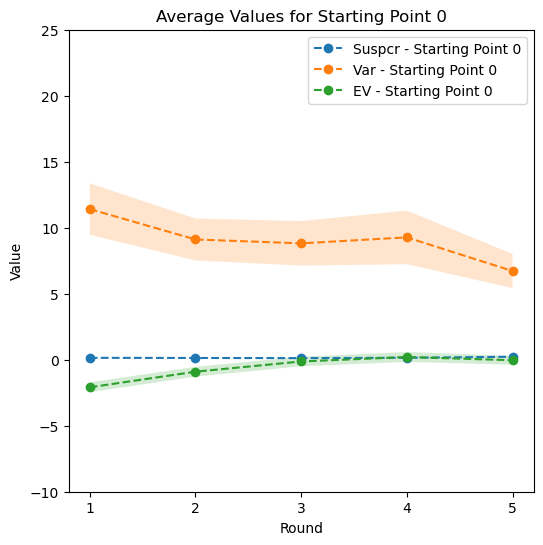

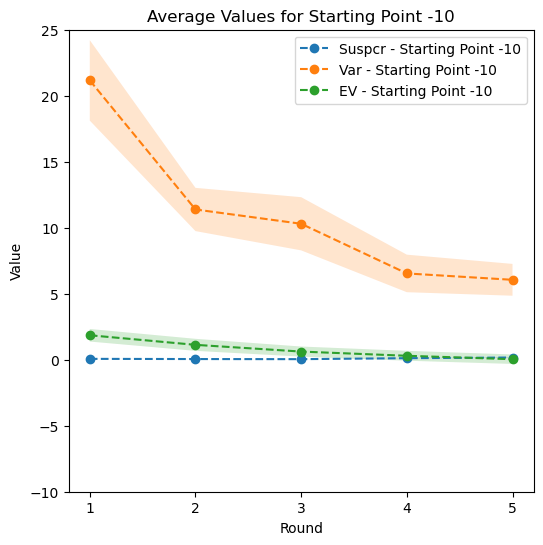

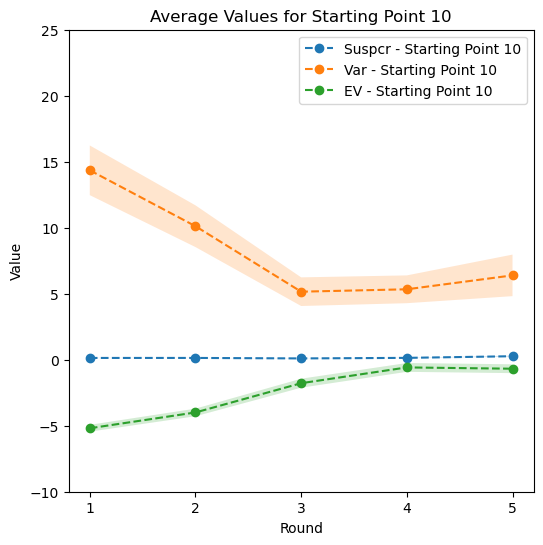

In [1387]:
plotsusmod_start(game_dicts)


In [1388]:
sim_dict['pair_min_EV_Var']

array([[[-6.  , 16.  ],
        [-6.5 , 12.25],
        [-6.5 , 20.25],
        [-5.5 , 20.25],
        [-6.  , 25.  ]],

       [[-7.  ,  9.  ],
        [-7.  , 16.  ],
        [-8.5 ,  6.25],
        [-7.  , 16.  ],
        [-6.  , 16.  ]],

       [[-7.5 ,  6.25],
        [-4.5 ,  2.25],
        [-7.  , 16.  ],
        [-8.5 ,  6.25],
        [-6.5 , 20.25]],

       [[-5.5 ,  6.25],
        [-6.5 , 12.25],
        [-6.5 , 12.25],
        [-5.5 ,  6.25],
        [-6.  , 25.  ]],

       [[-6.5 ,  6.25],
        [-7.  ,  9.  ],
        [-6.5 ,  6.25],
        [-6.  , 16.  ],
        [-5.5 , 20.25]],

       [[-5.5 ,  6.25],
        [-6.  , 25.  ],
        [-6.5 , 12.25],
        [-6.5 , 20.25],
        [-6.5 , 20.25]],

       [[-8.  ,  9.  ],
        [-6.5 , 20.25],
        [-7.  , 16.  ],
        [-5.5 , 30.25],
        [-6.5 ,  6.25]],

       [[-5.5 , 30.25],
        [-5.5 , 20.25],
        [-8.  ,  9.  ],
        [-8.  ,  9.  ],
        [-6.5 , 20.25]],

       [[-7.  ,  9.  ],


In [1437]:
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

def plot_variance(game_dicts):
    # Step 1: Group games by starting point and collect variance data
    grouped_variances = {}
    data = []
    for participant, thegame in game_dicts.items():
        starting_point = thegame['starting_point']
        if starting_point not in grouped_variances:
            grouped_variances[starting_point] = []
        grouped_variances[starting_point].append(thegame['pair_var'])
        
        # Collect data for ANOVA
        for i in range(len(thegame['pair_var'])):
            data.append({
                'Participant': participant,
                'Round': i + 1,
                'Starting_Point': starting_point,
                'Variance': thegame['pair_var'][i]
            })

    # Convert data to DataFrame for ANOVA
    df = pd.DataFrame(data)

    # Perform ANOVA
    model = ols('Variance ~ C(Starting_Point)', data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print("ANOVA Results:\n", anova_table)

    # Perform Tukey's HSD test if ANOVA is significant
    if anova_table['PR(>F)'][0] < 0.05:
        tukey = pairwise_tukeyhsd(endog=df['Variance'], groups=df['Starting_Point'], alpha=0.05)
        print("\nTukey's HSD Test Results:\n", tukey)

    # Step 2: Compute the average variance and standard error for each starting point group
    plt.figure(figsize=(8, 6))
    x = range(1, len(grouped_variances[next(iter(grouped_variances))][0]) + 1)

    # Add the average values from pair_min_EV as a gray line
    pair_min_var = sim_dict['pair_min_Var']
    round_averages_var = np.mean(pair_min_var, axis=(0, 2))
    var_std_err = np.std(pair_min_var, axis=(0, 2)) / np.sqrt(pair_min_var.shape[0])
    plt.plot(x, round_averages_var, '--o', color='gray')
    # Plot shaded area for standard error
    plt.fill_between(x, round_averages_var - var_std_err, round_averages_var + var_std_err, color='lightgray', alpha=0.5)
    
    for starting_point, variances in grouped_variances.items():
        var_array = np.array(variances)
        avg_var = np.mean(var_array, axis=0)
        std_error_var = np.std(var_array, axis=0) / np.sqrt(var_array.shape[0])

        if starting_point == -10:
            color = 'blue'
        elif starting_point == 0:
            color = 'orange'
        elif starting_point == 10:
            color = 'green'

        # Plot each starting point group
        plt.plot(x, avg_var, '-o', label=f'Var - Starting Point {starting_point}', color=color)
        plt.fill_between(x, avg_var - std_error_var, avg_var + std_error_var, alpha=0.2, color=color)

    # Customizing the legend order
    handles, labels = plt.gca().get_legend_handles_labels()
    legend_order = ['Var - Starting Point -10', 'Var - Starting Point 0', 'Var - Starting Point 10']
    ordered_handles_labels = sorted(zip(handles, labels), key=lambda x: legend_order.index(x[1]))
    handles, labels = zip(*ordered_handles_labels)

    plt.xlabel('Round', fontsize=13)
    plt.ylabel('Variance', fontsize=13)
    plt.title('Average Variance for Different Starting Points, 3rd Person', fontsize=13)
    plt.xticks(ticks=x, fontsize=13) 
    plt.yticks(fontsize=13)
    plt.ylim(0, 25)
    plt.legend(handles, labels, fontsize=13)


    #random EV
    
        # Calculate standard errors (replace with your actual standard errors)
    std_error_0 = np.std(rand_var_starting_point_0) / np.sqrt(len(rand_var_starting_point_0))
  

        # Plot for Starting Point 0
    plt.plot(x, rand_var_starting_point_0, '--o', label='Average Rand Count 0', color='black', alpha = 0.6)
    plt.fill_between(x, rand_var_starting_point_0 - std_error_0, rand_var_starting_point_0 + std_error_0, color='black', alpha=0.2)

   
    plt.show()

ANOVA Results:
                           sum_sq      df         F    PR(>F)
C(Starting_Point)    2151.930474     2.0  3.329621  0.036067
Residual           493449.273775  1527.0       NaN       NaN


/var/folders/nt/_9zn1_f53t78gbrn3tjy134m0000gn/T/ipykernel_16528/661675285.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if anova_table['PR(>F)'][0] < 0.05:



Tukey's HSD Test Results:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   -10      0  -2.0211 0.1714  -4.662  0.6199  False
   -10     10  -2.8176 0.0332 -5.4586 -0.1767   True
     0     10  -0.7966  0.759 -3.4375  1.8444  False
----------------------------------------------------


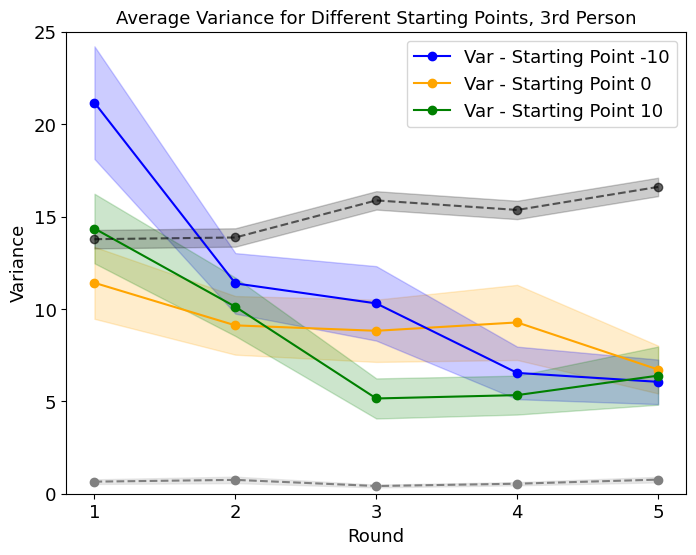

In [1438]:
plot_variance(game_dicts)


#plot_variance(game_dicts_first_half)

#plot_variance(game_dicts_second_half)

In [1431]:
def anova(game_dicts):

    grouped_var = {}
    data = []
    for participant, thegame in game_dicts.items():
        starting_point = thegame['starting_point']
        if starting_point not in grouped_var:
            grouped_var[starting_point] = []
        grouped_var[starting_point].append(thegame['pair_var'])

        # Collect data for ANOVA
        for i in range(len(thegame['pair_var'])):
            data.append({
                'Participant': participant,
                'Round': i + 1,
                'Starting_Point': starting_point,
                'Var': thegame['pair_var'][i]
            })

    # Convert data to DataFrame for ANOVA
    df = pd.DataFrame(data)

    # Prepare data for ANOVA including the round information
    data_for_anova_var = df.copy()
    data_for_anova_var = data_for_anova_var[['Round', 'Starting_Point', 'Var']]
    data_for_anova_var['Starting_Point'] = pd.Categorical(data_for_anova_var['Starting_Point'])

    # Run ANOVA with both round and starting point as factors for Var
    model_var = ols('Var ~ C(Round) * C(Starting_Point)', data=data_for_anova_var).fit()
    anova_results_var = anova_lm(model_var)

    print("ANOVA Results for Var:\n", anova_results_var)

    # Interpret the results
    if anova_results_var['PR(>F)']['C(Round)'] < 0.05:
        print("There is a statistically significant difference in Var due to the round.")
    else:
        print("There is no statistically significant difference in Var due to the round.")

    if anova_results_var['PR(>F)']['C(Starting_Point)'] < 0.05:
        print("There is a statistically significant difference in Var due to the starting point.")
    else:
        print("There is no statistically significant difference in Var due to the starting point.")

    if anova_results_var['PR(>F)']['C(Round):C(Starting_Point)'] < 0.05:
        print("There is a statistically significant interaction effect between round and starting point.")
    else:
        print("There is no statistically significant interaction effect between round and starting point.")

    # Perform Tukey's HSD test if ANOVA is significant
    if (anova_results_var['PR(>F)']['C(Round)'] < 0.05 or 
        anova_results_var['PR(>F)']['C(Starting_Point)'] < 0.05 or 
        anova_results_var['PR(>F)']['C(Round):C(Starting_Point)'] < 0.05):
        
        print("\nPerforming Tukey's HSD test for pairwise comparisons of Var...\n")
        tukey_var = pairwise_tukeyhsd(endog=data_for_anova_var['Var'],
                                      groups=data_for_anova_var['Starting_Point'].astype(str) + '_' + data_for_anova_var['Round'].astype(str),
                                      alpha=0.05)
        print(tukey_var)

anova(game_dicts)

ANOVA Results for Var:
                                 df         sum_sq      mean_sq          F  \
C(Round)                       4.0   17103.621324  4275.905331  13.758157   
C(Starting_Point)              2.0    2151.930474  1075.965237   3.462027   
C(Round):C(Starting_Point)     8.0    5497.953922   687.244240   2.211278   
Residual                    1515.0  470847.698529   310.790560        NaN   

                                  PR(>F)  
C(Round)                    5.033801e-11  
C(Starting_Point)           3.161450e-02  
C(Round):C(Starting_Point)  2.424165e-02  
Residual                             NaN  
There is a statistically significant difference in Var due to the round.
There is a statistically significant difference in Var due to the starting point.
There is a statistically significant interaction effect between round and starting point.

Performing Tukey's HSD test for pairwise comparisons of Var...

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 grou

In [1392]:

def plot_ev(game_dicts):
    # Step 1: Group games by starting point and collect variance data
    grouped_ev = {}
    data = []
    for participant, thegame in game_dicts.items():
        starting_point = thegame['starting_point']
        if starting_point not in grouped_ev:
            grouped_ev[starting_point] = []
        grouped_ev[starting_point].append(thegame['pair_ev'])


        # Collect data for ANOVA
        for i in range(len(thegame['pair_var'])):
            data.append({
                'Participant': participant,
                'Round': i + 1,
                'Starting_Point': starting_point,
                'EV': thegame['pair_ev'][i]
            })

    # Convert data to DataFrame for ANOVA
    df = pd.DataFrame(data)

    # Perform ANOVA
    model = ols('EV ~ C(Starting_Point)', data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print("ANOVA Results:\n", anova_table)

    # Perform Tukey's HSD test if ANOVA is significant
    if anova_table['PR(>F)'][0] < 0.05:
        tukey = pairwise_tukeyhsd(endog=df['EV'], groups=df['Starting_Point'], alpha=0.05)
        print("\nTukey's HSD Test Results:\n", tukey)
        print("\nAdjusted p-values:\n", tukey.pvalues)



    # Step 2: Compute the average variance and standard error for each starting point group
    plt.figure(figsize=(8, 6))
    x = range(1, len(grouped_ev[next(iter(grouped_ev))][0]) + 1)
    
    # Collect handles and labels for custom legend
    handles = []
    labels = []

    for starting_point, ev in grouped_ev.items():
        ev_array = np.array(ev)
        avg_ev = np.mean(ev_array, axis=0)
        std_error_ev = np.std(ev_array, axis=0) / np.sqrt(ev_array.shape[0])
    
        if starting_point == -10:
            color = 'blue'
        elif starting_point == 0:
            color = 'orange'
        elif starting_point == 10:
            color = 'green'

        # Plot each starting point group
        handle, = plt.plot(x, avg_ev, '-o', label=f'EV - Starting Point {starting_point}', color=color)
        plt.fill_between(x, avg_ev - std_error_ev, avg_ev + std_error_ev, alpha=0.2, color=color)

        # Append handles and labels for custom legend
        handles.append(handle)
        labels.append(f'EV - Starting Point {starting_point}')

    # Add the average values from pair_min_EV as a gray line
    pair_min_EV = sim_dict['pair_min_EV']
    round_averages_EV = np.mean(pair_min_EV, axis=(0, 2))
    ev_std_err = np.std(pair_min_EV, axis=(0, 2)) / np.sqrt(pair_min_EV.shape[0])
    plt.plot(x, round_averages_EV, '--o',color='gray', label='Average minimal EV', alpha = 0.6)
    # Plot shaded area for standard error
    plt.fill_between(x, round_averages_EV - ev_std_err, round_averages_EV + ev_std_err, color='gray', alpha=0.2)


    print(round_averages_EV)

    # Add the average values from pair_min_Var as a gray line
    pair_min_Var = sim_dict['pair_min_Var']
    round_averages_Var = np.mean(pair_min_Var, axis=(0, 2))
    #plt.plot(x, round_averages_Var, color='black', label='Average minimal Var')

    #EV + Variance
    var_and_EV_sum = round_averages_EV + round_averages_Var 
    #plt.plot(x, var_and_EV_sum, color='yellow', label='Average minimal EV + Minimal Var')

    #EV - Variance
    var_and_EV_diff = round_averages_EV - round_averages_Var 
    #plt.plot(x, var_and_EV_diff, color='blue', label='Average minimal EV - Minimal Var')

    # Add the average values from pair_min_EV as a gray line
    # Splitting the array into EV and Var arrays
    # EV_array = sim_dict['pair_min_EV_Var'][:, :, 0]
    #Add average var when trying to minimise EV
    #Var_array = sim_dict['pair_min_EV_Var'][:, :, 1]
    # Calculate mean separately for EV and Var arrays
    #mean_EV_Var = np.mean(EV_array, axis=(0))
    #mean_Var_EV = np.mean(Var_array, axis=(0))
    #plt.plot(x, mean_EV_Var, color='brown', label='Average minimal EV when minimising Var')
    #plt.plot(x, mean_Var_EV, color='brown', label='Average minimal Var when minimising EV')

    plt.xlabel('Round', fontsize ='13')
    plt.ylabel('Pair EV', fontsize ='13')
    plt.title('Average EV for Different Starting Points, 1st Person', fontsize ='13')
    plt.xticks(ticks=x, fontsize ='13') 
    plt.yticks(fontsize ='13')
    plt.ylim(-7, 3)

    # Sort handles and labels by starting point
    def sort_key(label):
        if "Starting Point -10" in label:
            return 0
        elif "Starting Point 0" in label:
            return 1
        elif "Starting Point 10" in label:
            return 2
        return 3

    sorted_handles_labels = sorted(zip(handles, labels), key=lambda hl: sort_key(hl[1]))
    sorted_handles, sorted_labels = zip(*sorted_handles_labels)



    #random EV
    
        # Calculate standard errors (replace with your actual standard errors)
    std_error_0 = np.std(rand_ev_starting_point_0) / np.sqrt(len(rand_ev_starting_point_0))
    std_error_10 = np.std(rand_ev_starting_point_10) / np.sqrt(len(rand_ev_starting_point_10))
    std_error_minus_10 = np.std(rand_ev_starting_point_minus_10) / np.sqrt(len(rand_ev_starting_point_minus_10))


        # Plot for Starting Point 0
    plt.plot(x, rand_ev_starting_point_0, '--o', label='Average Rand Count 0', color='black', alpha = 0.6)
    plt.fill_between(x, rand_ev_starting_point_0 - std_error_0, rand_ev_starting_point_0 + std_error_0, color='black', alpha=0.2)

   

    # Create custom legend with sorted handles and labels
    #plt.legend(sorted_handles, sorted_labels)
    plt.show()

In [1436]:
#simulations means and stderr
mean = np.mean(rand_ev_starting_point_0)
std_error_0 = np.std(rand_ev_starting_point_0) / np.sqrt(len(rand_ev_starting_point_0))

print(mean)
print(std_error_0)


pair_min_EV = sim_dict['pair_min_EV']
round_averages_EV = np.mean(pair_min_EV, axis=(0, 2))
ev_std_err = np.std(pair_min_EV, axis=(0, 2)) / np.sqrt(pair_min_EV.shape[0])

print(np.mean(round_averages_EV))
print(np.mean(ev_std_err))


-0.1375
0.08874815247598809
-6.433333333333333
0.1818466392708554


ANOVA Results:
                          sum_sq      df          F        PR(>F)
C(Starting_Point)   2685.021895     2.0  88.608636  3.906573e-37
Residual           23135.602941  1527.0        NaN           NaN


/var/folders/nt/_9zn1_f53t78gbrn3tjy134m0000gn/T/ipykernel_16528/3234199167.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if anova_table['PR(>F)'][0] < 0.05:



Tukey's HSD Test Results:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
   -10      0  -1.3794   0.0 -1.9513 -0.8076   True
   -10     10  -3.2333   0.0 -3.8052 -2.6615   True
     0     10  -1.8539   0.0 -2.4258 -1.2821   True
---------------------------------------------------

Adjusted p-values:
 [5.43955194e-08 1.40176759e-12 1.54942725e-12]
[-6.47222222 -6.36111111 -6.66666667 -6.5        -6.16666667]


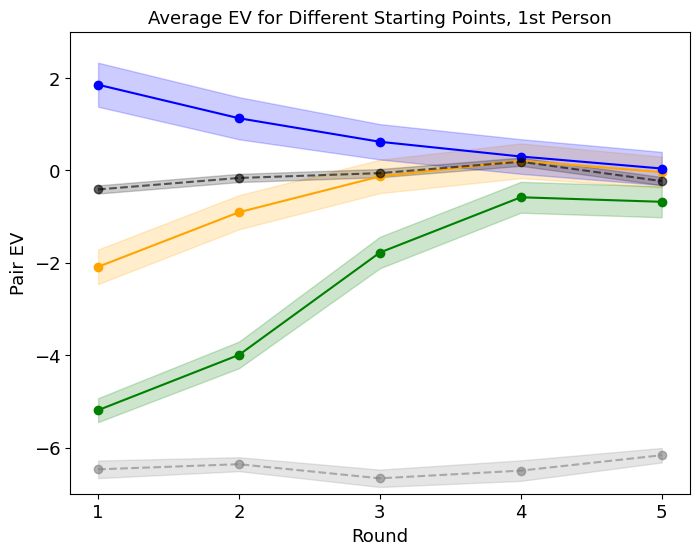

In [1393]:
plot_ev(game_dicts)

#plot_ev(game_dicts_first_half, 'First half')

#plot_ev(game_dicts_second_half, 'Second half')

In [1394]:
#check anova including roundss

def anova (game_dicts):

    grouped_ev = {}
    data = []
    for participant, thegame in game_dicts.items():
        starting_point = thegame['starting_point']
        if starting_point not in grouped_ev:
            grouped_ev[starting_point] = []
        grouped_ev[starting_point].append(thegame['pair_ev'])


        # Collect data for ANOVA
        for i in range(len(thegame['pair_var'])):
            data.append({
                'Participant': participant,
                'Round': i + 1,
                'Starting_Point': starting_point,
                'EV': thegame['pair_ev'][i]
            })

    # Convert data to DataFrame for ANOVA
    df = pd.DataFrame(data)

    # Prepare data for ANOVA including the round information
    data_for_anova_ev = df.copy()
    data_for_anova_ev = data_for_anova_ev[['Round', 'Starting_Point', 'EV']]
    data_for_anova_ev['Starting_Point'] = pd.Categorical(data_for_anova_ev['Starting_Point'])

    # Run ANOVA with both round and starting point as factors for EV
    model_ev = ols('EV ~ C(Round) * C(Starting_Point)', data=data_for_anova_ev).fit()
    anova_results_ev = anova_lm(model_ev)

    print("ANOVA Results for EV:\n", anova_results_ev)

    # Interpret the results
    if anova_results_ev['PR(>F)']['C(Round)'] < 0.05:
        print("There is a statistically significant difference in EV due to the round.")
    else:
        print("There is no statistically significant difference in EV due to the round.")

    if anova_results_ev['PR(>F)']['C(Starting_Point)'] < 0.05:
        print("There is a statistically significant difference in EV due to the starting point.")
    else:
        print("There is no statistically significant difference in EV due to the starting point.")

    if anova_results_ev['PR(>F)']['C(Round):C(Starting_Point)'] < 0.05:
        print("There is a statistically significant interaction effect between round and starting point.")
    else:
        print("There is no statistically significant interaction effect between round and starting point.")

    # Perform Tukey's HSD test if ANOVA is significant
    if (anova_results_ev['PR(>F)']['C(Round)'] < 0.05 or 
        anova_results_ev['PR(>F)']['C(Starting_Point)'] < 0.05 or 
        anova_results_ev['PR(>F)']['C(Round):C(Starting_Point)'] < 0.05):
        
        print("\nPerforming Tukey's HSD test for pairwise comparisons of EV...\n")
        tukey_ev = pairwise_tukeyhsd(endog=data_for_anova_ev['EV'],
                                    groups=data_for_anova_ev['Starting_Point'].astype(str) + '_' + data_for_anova_ev['Round'].astype(str),
                                    alpha=0.05)
        print(tukey_ev)

anova(game_dicts)

ANOVA Results for EV:
                                 df        sum_sq      mean_sq          F  \
C(Round)                       4.0    697.139542   174.284886  12.671618   
C(Starting_Point)              2.0   2685.021895  1342.510948  97.609069   
C(Round):C(Starting_Point)     8.0   1601.218301   200.152288  14.552342   
Residual                    1515.0  20837.245098    13.753957        NaN   

                                  PR(>F)  
C(Round)                    3.807260e-10  
C(Starting_Point)           1.336756e-40  
C(Round):C(Starting_Point)  1.231928e-20  
Residual                             NaN  
There is a statistically significant difference in EV due to the round.
There is a statistically significant difference in EV due to the starting point.
There is a statistically significant interaction effect between round and starting point.

Performing Tukey's HSD test for pairwise comparisons of EV...

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandif

In [1395]:
#stats against null hypothesis per round

from scipy.stats import ttest_1samp

# Define starting points
starting_points = [-10, 0, 10]

# Iterate over each starting point
for starting_point in starting_points:
    print(f"Starting Point {starting_point}:")
    
    # Get EV data for the starting point
    ev_data = [game_dicts[participant]['pair_ev'] for participant, game_data in game_dicts.items() if game_data['starting_point'] == starting_point]
    
    # Flatten the nested list
    ev_data_flat = [item for sublist in ev_data for item in sublist]
    
    # Calculate mean of EV for the starting point
    ev_mean = np.mean(ev_data_flat)
    
    # Perform one-sample t-test
    t_stat, p_value = ttest_1samp(ev_data_flat, 0)
    
    # Print results
    print(f"  Mean = {ev_mean}, t-statistic = {t_stat}, p-value = {p_value}")

Starting Point -10:
  Mean = 0.7872549019607843, t-statistic = 4.2125735027499625, p-value = 2.9865530552251e-05
Starting Point 0:
  Mean = -0.592156862745098, t-statistic = -3.5492919633293587, p-value = 0.0004220588460573318
Starting Point 10:
  Mean = -2.446078431372549, t-statistic = -15.064917052220489, p-value = 1.1180511518873363e-42


In [1396]:

def plot_difference_var_ev(game_dicts):
    # Step 1: Group games by starting point and collect EV and variance data
    grouped_ev = {}
    grouped_variances = {}
    for participant, thegame in game_dicts.items():
        starting_point = thegame['starting_point']
        if starting_point not in grouped_ev:
            grouped_ev[starting_point] = []
            grouped_variances[starting_point] = []
        grouped_ev[starting_point].append(thegame['pair_ev'])
        grouped_variances[starting_point].append(thegame['pair_var'])



    # Step 2: Compute the average and standard error for each starting point group
    plt.figure(figsize=(10, 8))
    x = range(1, len(grouped_ev[next(iter(grouped_ev))][0]) + 1)

    for starting_point, ev in grouped_ev.items():
        ev_array = np.array(ev)
        var_array = np.array(grouped_variances[starting_point])

        avg_ev = np.mean(ev_array, axis=0)
        std_error_ev = np.std(ev_array, axis=0) / np.sqrt(ev_array.shape[0])

        avg_var = np.mean(var_array, axis=0)
        std_error_var = np.std(var_array, axis=0) / np.sqrt(var_array.shape[0])

        # Calculate the difference between average variance and average EV
        avg_diff = avg_var - avg_ev
        std_error_diff = np.sqrt(std_error_var**2 + std_error_ev**2)  # Combined standard error


        if starting_point == -10:
            color = 'blue'
        elif starting_point == 0:
            color = 'orange'
        elif starting_point == 10:
            color = 'green'

        # Plot the difference
        plt.plot(x, avg_diff, '--o', label=f'Difference - Starting Point {starting_point}', color = color)
        plt.fill_between(x, avg_diff - std_error_diff, avg_diff + std_error_diff, alpha=0.2, color = color)

    plt.xlabel('Round')
    plt.ylabel('Difference (Variance - EV)')
    plt.title('Difference between Average Variance and Average EV for Different Starting Points, 1st Person')
    plt.xticks(ticks=x)
    plt.legend()
    plt.show()

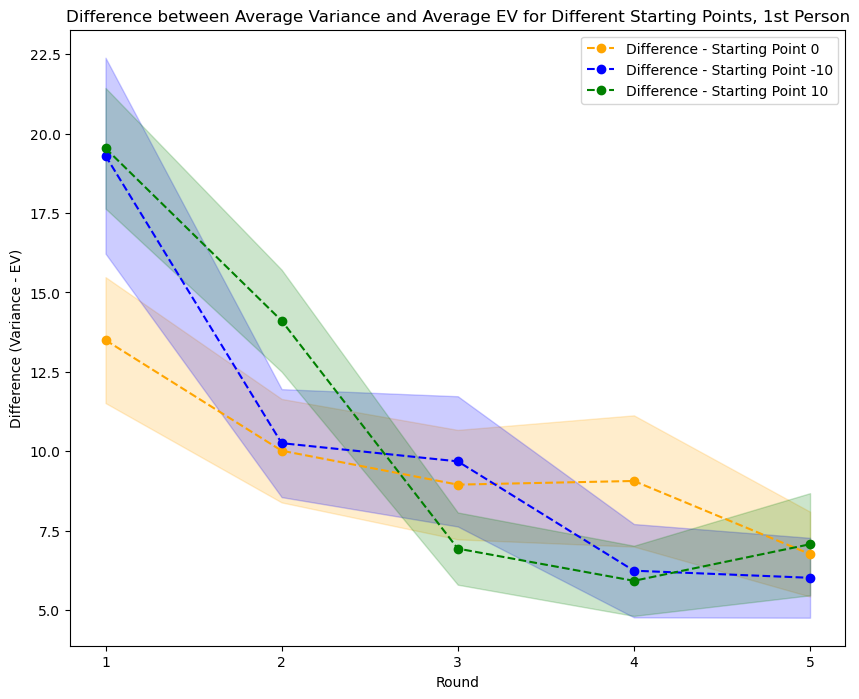

In [1397]:
plot_difference_var_ev(game_dicts)

In [1398]:

def plot_difference_ev_var(game_dicts):
    # Step 1: Group games by starting point and collect EV and variance data
    grouped_ev = {}
    grouped_variances = {}
    for participant, thegame in game_dicts.items():
        starting_point = thegame['starting_point']
        if starting_point not in grouped_ev:
            grouped_ev[starting_point] = []
            grouped_variances[starting_point] = []
        grouped_ev[starting_point].append(thegame['pair_ev'])
        grouped_variances[starting_point].append(thegame['pair_var'])

    # Step 2: Compute the average and standard error for each starting point group
    plt.figure(figsize=(10, 8))
    x = range(1, len(grouped_ev[next(iter(grouped_ev))][0]) + 1)

    for starting_point, ev in grouped_ev.items():
        ev_array = np.array(ev)
        var_array = np.array(grouped_variances[starting_point])

        avg_ev = np.mean(ev_array, axis=0)
        std_error_ev = np.std(ev_array, axis=0) / np.sqrt(ev_array.shape[0])

        avg_var = np.mean(var_array, axis=0)
        std_error_var = np.std(var_array, axis=0) / np.sqrt(var_array.shape[0])

        # Calculate the difference between average variance and average EV
        avg_diff = avg_ev + avg_var
        std_error_diff = np.sqrt(std_error_ev**2 + std_error_var**2)  # Combined standard error


        if starting_point == -10:
            color = 'blue'
        elif starting_point == 0:
            color = 'orange'
        elif starting_point == 10:
            color = 'green'


        # Plot the difference
        plt.plot(x, avg_diff, '--o', label=f'Difference + Starting Point {starting_point}', color = color)
        plt.fill_between(x, avg_diff - std_error_diff, avg_diff + std_error_diff, alpha=0.2, color = color)

    plt.xlabel('Round')
    plt.ylabel('Difference (EV + Variance)')
    plt.title('Difference between Average EV and Average Variance for Different Starting Points, 1st Person')
    plt.ylim(0,30)
    plt.xticks(ticks=x)
    plt.legend()
    plt.show()

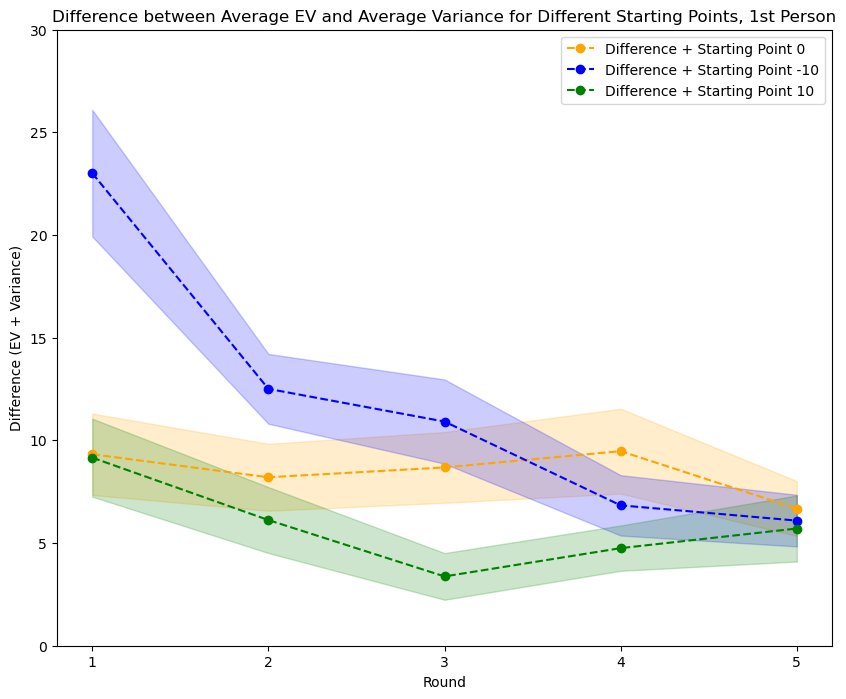

In [1399]:
plot_difference_ev_var(game_dicts)

In [1400]:
def plot_count(df, time_of_game):
    # Group by round_number and starting_point, and calculate the mean and standard error of amount_calculation
    grouped_mean = df.groupby(['round_number', 'starting_point'])['amount_calculation'].mean().unstack()
    grouped_std = df.groupby(['round_number', 'starting_point'])['amount_calculation'].std().unstack()
    n = df.groupby(['round_number', 'starting_point'])['amount_calculation'].count().unstack()

    # Calculate standard error
    grouped_se = grouped_std / np.sqrt(n)

    # Define the starting point values
    starting_point_values = {0: 0, -10: -10, 10: 10}

    # Plotting
    plt.figure(figsize=(10, 6))


    # Adding the initial number (index -1) to the arrays
    new_average_min_EV_count_0 = np.insert(average_min_EV_count_0, 0, 0)
    new_std_err_min_EV_count_0 = np.insert(std_err_min_EV_count_0, 0, 0)

    # Creating x-values starting from -1
    x_values = np.arange(-1, len(new_average_min_EV_count_0) - 1)

    # Plotting the data
    plt.plot(x_values, new_average_min_EV_count_0, marker='o', linestyle='--', color='orange', label='Minimize EV Starting Point 0', alpha =0.4)
    plt.fill_between(x_values, 
                    new_average_min_EV_count_0 - new_std_err_min_EV_count_0, 
                    new_average_min_EV_count_0 + new_std_err_min_EV_count_0, 
                    color='orange', alpha=0.2)
    
    # Adding the initial number (index -1) to the arrays
    new_average_min_Var_count_0 = np.insert(average_min_Var_count_0, 0, 0)
    new_std_err_min_Var_count_0 = np.insert(std_err_min_Var_count_0, 0, 0)

    # Creating x-values starting from -1
    x_values = np.arange(-1, len(new_average_min_Var_count_0) - 1)

    '''
    # Plotting the data
    plt.plot(x_values, new_average_min_Var_count_0, marker='o', linestyle='--', color='orange', label='Minimize Var Starting Point 0')
    plt.fill_between(x_values, 
                    new_average_min_Var_count_0 - new_std_err_min_Var_count_0, 
                    new_average_min_Var_count_0 + new_std_err_min_Var_count_0, 
                    color='orange', alpha=0.3)
    '''
    # Adding the initial number (index -1) to the arrays
    new_average_min_EV_count_10 = np.insert(average_min_EV_count_10, 0, 10)
    new_std_err_min_EV_count_10 = np.insert(std_err_min_EV_count_10, 0, 0)
    

    # Creating x-values starting from -1
    x_values = np.arange(-1, len(new_average_min_EV_count_10) - 1)

    
    # Plotting the data
    plt.plot(x_values, new_average_min_EV_count_10, marker='o', linestyle='--', color='green', label='Minimize EV Starting Point 10', alpha =0.4)
    plt.fill_between(x_values, 
                    new_average_min_EV_count_10 - new_std_err_min_EV_count_10, 
                    new_average_min_EV_count_10 + new_std_err_min_EV_count_10, 
                    color='green', alpha=0.2)
    
    # Adding the initial number (index -1) to the arrays
    new_average_min_Var_count_10 = np.insert(average_min_Var_count_10, 0, 10)
    new_std_err_min_Var_count_10 = np.insert(std_err_min_Var_count_10, 0, 0)

    # Creating x-values starting from -1
    x_values = np.arange(-1, len(new_average_min_Var_count_10) - 1)

    '''
    # Plotting the data
    plt.plot(x_values, new_average_min_Var_count_10, marker='o', linestyle='--', color='green', label='Minimize Var Starting Point 10', alpha =0.4)
    plt.fill_between(x_values, 
                    new_average_min_Var_count_10 - new_std_err_min_Var_count_10, 
                    new_average_min_Var_count_10 + new_std_err_min_Var_count_10, 
                    color='green', alpha=0.3)

    '''

    new_average_min_EV_count_minus_10 = np.insert(average_min_EV_count_minus_10, 0, -10)
    new_std_err_min_EV_count_minus_10 = np.insert(std_err_min_EV_count_minus_10, 0, 0)

    # Creating x-values starting from -1
    x_values = np.arange(-1, len(new_average_min_EV_count_minus_10) - 1)

    
    # Plotting the data
    plt.plot(x_values, new_average_min_EV_count_minus_10, marker='o', linestyle='--', color='blue', label='Minimize EV Starting Point -10', alpha =0.4)
    plt.fill_between(x_values, 
                    new_average_min_EV_count_minus_10 - new_std_err_min_EV_count_minus_10, 
                    new_average_min_EV_count_minus_10 + new_std_err_min_EV_count_minus_10, 
                    color='blue', alpha=0.2)
    
    
    
    # Adding the initial number (index -1) to the arrays
    new_average_min_Var_count_minus_10 = np.insert(average_min_Var_count_minus_10, 0, -10)
    new_std_err_min_Var_count_minus_10 = np.insert(std_err_min_Var_count_minus_10, 0, 0)

    # Creating x-values starting from -1
    x_values = np.arange(-1, len(new_average_min_Var_count_minus_10) - 1)

    '''
    # Plotting the data
    plt.plot(x_values, new_average_min_Var_count_minus_10, marker='o', linestyle='--', color='blue', label='Minimize Var Starting Point -10')
    plt.fill_between(x_values, 
                    new_average_min_Var_count_minus_10 - new_std_err_min_Var_count_minus_10, 
                    new_average_min_Var_count_minus_10 + new_std_err_min_Var_count_minus_10, 
                    color='blue', alpha=0.3)
    '''

    #Adding random player

    #Start 0
    # Adding the initial number (index -1) to the arrays
    new_average_rand_count_0 = np.insert(average_rand_count_0, 0, 0)
    new_std_err_rand_count_0 = np.insert(final_rand_std_err, 0, 0)
    
    # Creating x-values starting from -1
    x_values = np.arange(-1, len(new_average_rand_count_0) - 1)

    
    # Plotting the data
    plt.plot(x_values, new_average_rand_count_0, marker='o', linestyle='--', color='black', label='Minimize EV Starting Point 10', alpha =0.4)
    plt.fill_between(x_values, 
                    new_average_rand_count_0 - new_std_err_rand_count_0, 
                    new_average_rand_count_0 + new_std_err_rand_count_0, 
                    color='black', alpha=0.2)
    
    
    #Start 10

    new_average_rand_count_10 = np.insert(average_rand_count_10, 0, 10)
    new_std_err_rand_count_10 = np.insert(final_rand_std_err, 0, 0)
    
    # Creating x-values starting from -1
    x_values = np.arange(-1, len(new_average_rand_count_10) - 1)

    
    # Plotting the data
    plt.plot(x_values, new_average_rand_count_10, marker='o', linestyle='--', color='black', label='Minimize EV Starting Point 10', alpha =0.4)
    plt.fill_between(x_values, 
                    new_average_rand_count_10 - new_std_err_rand_count_10, 
                    new_average_rand_count_10 + new_std_err_rand_count_10, 
                    color='black', alpha=0.2)
    
    #Start -10


    new_average_rand_count_minus_10 = np.insert(average_rand_count_minus_10, 0, -10)
    new_std_err_rand_count_minus_10 = np.insert(final_rand_std_err, 0, 0)
    
    # Creating x-values starting from -1
    x_values = np.arange(-1, len(new_average_rand_count_minus_10) - 1)

    
    # Plotting the data
    plt.plot(x_values, new_average_rand_count_minus_10, marker='o', linestyle='--', color='black', label='Minimize EV Starting Point 10', alpha =0.4)
    plt.fill_between(x_values, 
                    new_average_rand_count_minus_10 - new_std_err_rand_count_minus_10, 
                    new_average_rand_count_minus_10 + new_std_err_rand_count_minus_10, 
                    color='black', alpha=0.2)




    for starting_point in grouped_mean.columns:
        mean_values = grouped_mean[starting_point].copy()
        se_values = grouped_se[starting_point]

        # Create new indices to include an additional initial round (e.g., -1)
        new_index = [-1] + list(grouped_mean.index)
        new_mean_values = np.insert(mean_values.values, 0, starting_point_values[starting_point])
        new_se_values = np.insert(se_values.values, 0, 0)  # Standard error for starting point can be zero or ignored

        if starting_point == -10:
            color = 'blue'
        elif starting_point == 0:
            color = 'orange'
        elif starting_point == 10:
            color = 'green'

        plt.plot(new_index, new_mean_values, marker='o', label=f'Starting Point {starting_point}', color=color)
        plt.fill_between(new_index, new_mean_values - new_se_values, new_mean_values + new_se_values, alpha=0.2, color=color)

        # Perform t-test with agent data (simulated data) and human data
        if starting_point == 0:
            agent_data_ev = new_average_min_EV_count_0  # Replace with your agent data for EV
            std_err_agent_data_ev = new_std_err_min_EV_count_0  # Replace with your agent standard error data for EV
            agent_data_var = new_average_min_Var_count_0  # Replace with your agent data for Var
            std_err_agent_data_var = new_std_err_min_Var_count_0  # Replace with your agent standard error data for Var
        elif starting_point == 10:
            agent_data_ev = new_average_min_EV_count_10  # Replace with your agent data for EV
            std_err_agent_data_ev = new_std_err_min_EV_count_10  # Replace with your agent standard error data for EV
            agent_data_var = new_average_min_Var_count_10  # Replace with your agent data for Var
            std_err_agent_data_var = new_std_err_min_Var_count_10  # Replace with your agent standard error data for Var
        elif starting_point == -10:
            agent_data_ev = new_average_min_EV_count_minus_10  # Replace with your agent data for EV
            std_err_agent_data_ev = new_std_err_min_EV_count_minus_10  # Replace with your agent standard error data for EV
            agent_data_var = new_average_min_Var_count_minus_10  # Replace with your agent data for Var
            std_err_agent_data_var = new_std_err_min_Var_count_minus_10  # Replace with your agent standard error data for Var

        human_data_ev = new_mean_values[1:]  # Remove the first index for EV
        human_data_var = new_mean_values[1:]  # Remove the first index for Var 
        agent_data_ev = agent_data_ev[1:]  # Remove the first index for EV
        agent_data_var = agent_data_var[1:]  # Remove the first index for Var 


        # Perform t-test for EV
        t_stat_ev, p_val_ev = ttest_ind(agent_data_ev, human_data_ev)
        df_ev = len(agent_data_ev) + len(human_data_ev) - 2
        print(f"Starting Point {starting_point} VS Agent (EV): t-statistic={t_stat_ev}, p-value={p_val_ev}, degrees of freedom={df_ev}")

        # Perform t-test for Var
        t_stat_var, p_val_var = ttest_ind(agent_data_var, human_data_var)
        df_var = len(agent_data_var) + len(human_data_var) - 2
        print(f"Starting Point {starting_point} VS Agent (Var): t-statistic={t_stat_var}, p-value={p_val_var}, degrees of freedom={df_var}")
            
    plt.xlabel('Round Number', fontsize=13)
    plt.ylabel('Average Amount Calculation', fontsize=13)
    plt.title('Average Amount Calculation per Round for Each Starting Point, 1st Person ' + time_of_game, fontsize=13)
    plt.xticks(ticks=range(-1, 5), fontsize=13)
    plt.yticks(fontsize=13)
    plt.axhline(y=3, color='r', linestyle='-', label='Threshold')
    plt.ylim(-45,15)

    #plt.legend(fontsize=13)
    plt.show()

    # Prepare data for ANOVA
    data_for_anova = df.copy()
    data_for_anova = data_for_anova[['round_number', 'starting_point', 'amount_calculation']]
    data_for_anova['starting_point'] = pd.Categorical(data_for_anova['starting_point'])

    # Run ANOVA with both round_number and starting_point as factors
    model = ols('amount_calculation ~ C(round_number) * C(starting_point)', data=data_for_anova).fit()
    anova_results = anova_lm(model)

    print("ANOVA Results:\n", anova_results)

    # Interpret the results
    if anova_results['PR(>F)']['C(round_number)'] < 0.05:
        print("There is a statistically significant difference in amount calculation due to the round number.")
    else:
        print("There is no statistically significant difference in amount calculation due to the round number.")

    if anova_results['PR(>F)']['C(starting_point)'] < 0.05:
        print("There is a statistically significant difference in amount calculation due to the starting point.")
    else:
        print("There is no statistically significant difference in amount calculation due to the starting point.")

    if anova_results['PR(>F)']['C(round_number):C(starting_point)'] < 0.05:
        print("There is a statistically significant interaction effect between round number and starting point.")
    else:
        print("There is no statistically significant interaction effect between round number and starting point.")

    # Perform Tukey's HSD test if ANOVA is significant
    if (anova_results['PR(>F)']['C(round_number)'] < 0.05 or 
        anova_results['PR(>F)']['C(starting_point)'] < 0.05 or 
        anova_results['PR(>F)']['C(round_number):C(starting_point)'] < 0.05):
        
        print("\nPerforming Tukey's HSD test for pairwise comparisons...\n")
        tukey = pairwise_tukeyhsd(endog=data_for_anova['amount_calculation'],
                                  groups=data_for_anova['starting_point'].astype(str) + '_' + data_for_anova['round_number'].astype(str),
                                  alpha=0.05)
        print(tukey)


Starting Point -10 VS Agent (EV): t-statistic=-5.144838261186373, p-value=0.0008798843978972383, degrees of freedom=8
Starting Point -10 VS Agent (Var): t-statistic=-3.546097391122563, p-value=0.007552328033081311, degrees of freedom=8
Starting Point 0 VS Agent (EV): t-statistic=-3.51160300562845, p-value=0.007942921059104175, degrees of freedom=8
Starting Point 0 VS Agent (Var): t-statistic=10.08055417701448, p-value=7.994409327623007e-06, degrees of freedom=8
Starting Point 10 VS Agent (EV): t-statistic=-2.0466914842091435, p-value=0.0748918866809099, degrees of freedom=8
Starting Point 10 VS Agent (Var): t-statistic=8.519771812916332, p-value=2.7681336763915387e-05, degrees of freedom=8


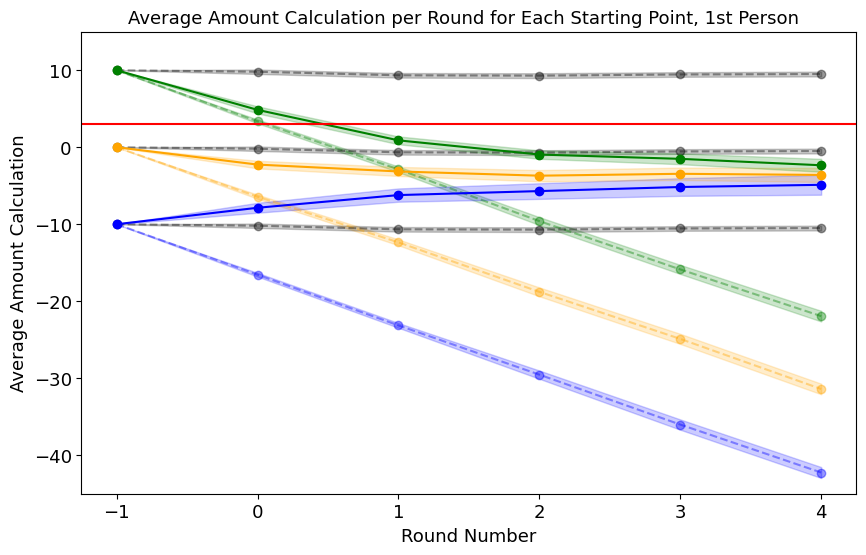

ANOVA Results:
                                        df         sum_sq      mean_sq  \
C(round_number)                       4.0     701.520261   175.380065   
C(starting_point)                     2.0    9693.541176  4846.770588   
C(round_number):C(starting_point)     8.0    3352.903268   419.112908   
Residual                           1515.0  100323.029412    66.219821   

                                           F        PR(>F)  
C(round_number)                     2.648453  3.192800e-02  
C(starting_point)                  73.192142  4.533881e-31  
C(round_number):C(starting_point)   6.329116  4.264995e-08  
Residual                                 NaN           NaN  
There is a statistically significant difference in amount calculation due to the round number.
There is a statistically significant difference in amount calculation due to the starting point.
There is a statistically significant interaction effect between round number and starting point.

Performing Tukey's HSD 

In [1401]:
plot_count (choice_filtered_df, ' ')
#plot_count (choice_filtered_df_first_half, 'First half')
#plot_count (choice_filtered_df_second_half, 'Second half')

In [1402]:
def plot_count_2(df, time_of_game):
    # Group by round_number and starting_point, and calculate the mean and standard error of amount_calculation
    grouped_mean = df.groupby(['round_number', 'starting_point'])['amount_calculation'].mean().unstack()
    grouped_std = df.groupby(['round_number', 'starting_point'])['amount_calculation'].std().unstack()
    n = df.groupby(['round_number', 'starting_point'])['amount_calculation'].count().unstack()

    # Calculate standard error
    grouped_se = grouped_std / np.sqrt(n)

    # Define the starting point values
    starting_point_values = {0: 0, -10: -10, 10: 10}

    # Plotting
    plt.figure(figsize=(10, 6))


    # Adding the initial number (index -1) to the arrays
    new_average_min_EV_count_0 = np.insert(average_min_EV_count_0, 0, 0)
    new_std_err_min_EV_count_0 = np.insert(std_err_min_EV_count_0, 0, 0)

    # Creating x-values starting from -1
    x_values = np.arange(-1, len(new_average_min_EV_count_0) - 1)

    '''
    # Plotting the data
    plt.plot(x_values, new_average_min_EV_count_0, marker='o', linestyle='--', color='orange', label='Minimize EV Starting Point 0')
    plt.fill_between(x_values, 
                    new_average_min_EV_count_0 - new_std_err_min_EV_count_0, 
                    new_average_min_EV_count_0 + new_std_err_min_EV_count_0, 
                    color='orange', alpha=0.2)
    '''
    
    # Adding the initial number (index -1) to the arrays
    new_average_min_Var_count_0 = np.insert(average_min_Var_count_0, 0, 0)
    new_std_err_min_Var_count_0 = np.insert(std_err_min_Var_count_0, 0, 0)

    # Creating x-values starting from -1
    x_values = np.arange(-1, len(new_average_min_Var_count_0) - 1)

    
    # Plotting the data
    plt.plot(x_values, new_average_min_Var_count_0, marker='o', linestyle='--', color='orange', label='Minimize Var Starting Point 0', alpha =0.4)
    plt.fill_between(x_values, 
                    new_average_min_Var_count_0 - new_std_err_min_Var_count_0, 
                    new_average_min_Var_count_0 + new_std_err_min_Var_count_0, 
                    color='orange', alpha=0.2)
    
    # Adding the initial number (index -1) to the arrays
    new_average_min_EV_count_10 = np.insert(average_min_EV_count_10, 0, 10)
    new_std_err_min_EV_count_10 = np.insert(std_err_min_EV_count_10, 0, 0)
    

    # Creating x-values starting from -1
    x_values = np.arange(-1, len(new_average_min_EV_count_10) - 1)

    '''
    # Plotting the data
    plt.plot(x_values, new_average_min_EV_count_10, marker='o', linestyle='--', color='green', label='Minimize EV Starting Point 10')
    plt.fill_between(x_values, 
                    new_average_min_EV_count_10 - new_std_err_min_EV_count_10, 
                    new_average_min_EV_count_10 + new_std_err_min_EV_count_10, 
                    color='green', alpha=0.2)
    '''

    # Adding the initial number (index -1) to the arrays
    new_average_min_Var_count_10 = np.insert(average_min_Var_count_10, 0, 10)
    new_std_err_min_Var_count_10 = np.insert(std_err_min_Var_count_10, 0, 0)

    # Creating x-values starting from -1
    x_values = np.arange(-1, len(new_average_min_Var_count_10) - 1)

    
    # Plotting the data
    plt.plot(x_values, new_average_min_Var_count_10, marker='o', linestyle='--', color='green', label='Minimize Var Starting Point 10', alpha =0.4)
    plt.fill_between(x_values, 
                    new_average_min_Var_count_10 - new_std_err_min_Var_count_10, 
                    new_average_min_Var_count_10 + new_std_err_min_Var_count_10, 
                    color='green', alpha=0.2)

    

    new_average_min_EV_count_minus_10 = np.insert(average_min_EV_count_minus_10, 0, -10)
    new_std_err_min_EV_count_minus_10 = np.insert(std_err_min_EV_count_minus_10, 0, 0)

    # Creating x-values starting from -1
    x_values = np.arange(-1, len(new_average_min_EV_count_minus_10) - 1)

    '''
    # Plotting the data
    plt.plot(x_values, new_average_min_EV_count_minus_10, marker='o', linestyle='--', color='blue', label='Minimize EV Starting Point -10')
    plt.fill_between(x_values, 
                    new_average_min_EV_count_minus_10 - new_std_err_min_EV_count_minus_10, 
                    new_average_min_EV_count_minus_10 + new_std_err_min_EV_count_minus_10, 
                    color='blue', alpha=0.2)
    '''
    
    
    # Adding the initial number (index -1) to the arrays
    new_average_min_Var_count_minus_10 = np.insert(average_min_Var_count_minus_10, 0, -10)
    new_std_err_min_Var_count_minus_10 = np.insert(std_err_min_Var_count_minus_10, 0, 0)

    # Creating x-values starting from -1
    x_values = np.arange(-1, len(new_average_min_Var_count_minus_10) - 1)

    
    # Plotting the data
    plt.plot(x_values, new_average_min_Var_count_minus_10, marker='o', linestyle='--', color='blue', label='Minimize Var Starting Point -10', alpha =0.4)
    plt.fill_between(x_values, 
                    new_average_min_Var_count_minus_10 - new_std_err_min_Var_count_minus_10, 
                    new_average_min_Var_count_minus_10 + new_std_err_min_Var_count_minus_10, 
                    color='blue', alpha=0.2)
    


    #Adding random player

    #Start 0
    # Adding the initial number (index -1) to the arrays
    new_average_rand_count_0 = np.insert(average_rand_count_0, 0, 0)
    new_std_err_rand_count_0 = np.insert(final_rand_std_err, 0, 0)
    
    # Creating x-values starting from -1
    x_values = np.arange(-1, len(new_average_rand_count_0) - 1)

    
    # Plotting the data
    plt.plot(x_values, new_average_rand_count_0, marker='o', linestyle='--', color='black', label='Minimize EV Starting Point 10', alpha =0.4)
    plt.fill_between(x_values, 
                    new_average_rand_count_0 - new_std_err_rand_count_0, 
                    new_average_rand_count_0 + new_std_err_rand_count_0, 
                    color='black', alpha=0.2)
    
    
    #Start 10

    new_average_rand_count_10 = np.insert(average_rand_count_10, 0, 10)
    new_std_err_rand_count_10 = np.insert(final_rand_std_err, 0, 0)
    
    # Creating x-values starting from -1
    x_values = np.arange(-1, len(new_average_rand_count_10) - 1)

    
    # Plotting the data
    plt.plot(x_values, new_average_rand_count_10, marker='o', linestyle='--', color='black', label='Minimize EV Starting Point 10', alpha =0.4)
    plt.fill_between(x_values, 
                    new_average_rand_count_10 - new_std_err_rand_count_10, 
                    new_average_rand_count_10 + new_std_err_rand_count_10, 
                    color='black', alpha=0.2)
    
    #Start -10


    new_average_rand_count_minus_10 = np.insert(average_rand_count_minus_10, 0, -10)
    new_std_err_rand_count_minus_10 = np.insert(final_rand_std_err, 0, 0)
    
    # Creating x-values starting from -1
    x_values = np.arange(-1, len(new_average_rand_count_minus_10) - 1)

    
    # Plotting the data
    plt.plot(x_values, new_average_rand_count_minus_10, marker='o', linestyle='--', color='black', label='Minimize EV Starting Point 10', alpha =0.4)
    plt.fill_between(x_values, 
                    new_average_rand_count_minus_10 - new_std_err_rand_count_minus_10, 
                    new_average_rand_count_minus_10 + new_std_err_rand_count_minus_10, 
                    color='black', alpha=0.2)





    for starting_point in grouped_mean.columns:
        mean_values = grouped_mean[starting_point].copy()
        se_values = grouped_se[starting_point]

        # Create new indices to include an additional initial round (e.g., -1)
        new_index = [-1] + list(grouped_mean.index)
        new_mean_values = np.insert(mean_values.values, 0, starting_point_values[starting_point])
        new_se_values = np.insert(se_values.values, 0, 0)  # Standard error for starting point can be zero or ignored

        if starting_point == -10:
            color = 'blue'
        elif starting_point == 0:
            color = 'orange'
        elif starting_point == 10:
            color = 'green'

        plt.plot(new_index, new_mean_values, marker='o', label=f'Starting Point {starting_point}', color=color)
        plt.fill_between(new_index, new_mean_values - new_se_values, new_mean_values + new_se_values, alpha=0.2, color=color)

        # Perform t-test with agent data (simulated data) and human data
        if starting_point == 0:
            agent_data_ev = new_average_min_EV_count_0  # Replace with your agent data for EV
            std_err_agent_data_ev = new_std_err_min_EV_count_0  # Replace with your agent standard error data for EV
            agent_data_var = new_average_min_Var_count_0  # Replace with your agent data for Var
            std_err_agent_data_var = new_std_err_min_Var_count_0  # Replace with your agent standard error data for Var
        elif starting_point == 10:
            agent_data_ev = new_average_min_EV_count_10  # Replace with your agent data for EV
            std_err_agent_data_ev = new_std_err_min_EV_count_10  # Replace with your agent standard error data for EV
            agent_data_var = new_average_min_Var_count_10  # Replace with your agent data for Var
            std_err_agent_data_var = new_std_err_min_Var_count_10  # Replace with your agent standard error data for Var
        elif starting_point == -10:
            agent_data_ev = new_average_min_EV_count_minus_10  # Replace with your agent data for EV
            std_err_agent_data_ev = new_std_err_min_EV_count_minus_10  # Replace with your agent standard error data for EV
            agent_data_var = new_average_min_Var_count_minus_10  # Replace with your agent data for Var
            std_err_agent_data_var = new_std_err_min_Var_count_minus_10  # Replace with your agent standard error data for Var

        human_data_ev = new_mean_values[1:]  # Remove the first index for EV
        human_data_var = new_mean_values[1:]  # Remove the first index for Var 
        agent_data_ev = agent_data_ev[1:]  # Remove the first index for EV
        agent_data_var = agent_data_var[1:]  # Remove the first index for Var 


        # Perform t-test for EV
        t_stat_ev, p_val_ev = ttest_ind(agent_data_ev, human_data_ev)
        df_ev = len(agent_data_ev) + len(human_data_ev) - 2
        print(f"Starting Point {starting_point} VS Agent (EV): t-statistic={t_stat_ev}, p-value={p_val_ev}, degrees of freedom={df_ev}")

        # Perform t-test for Var
        t_stat_var, p_val_var = ttest_ind(agent_data_var, human_data_var)
        df_var = len(agent_data_var) + len(human_data_var) - 2
        print(f"Starting Point {starting_point} VS Agent (Var): t-statistic={t_stat_var}, p-value={p_val_var}, degrees of freedom={df_var}")
            
    plt.xlabel('Round Number', fontsize=13)
    plt.ylabel('Average Amount Calculation', fontsize=13)
    plt.title('Average Amount Calculation per Round for Each Starting Point, 1st Person ' + time_of_game, fontsize=13)
    plt.xticks(ticks=range(-1, 5), fontsize=13)
    plt.yticks(fontsize=13)
    plt.axhline(y=3, color='r', linestyle='-', label='Threshold')
    plt.ylim(-30,15)

    #plt.legend(fontsize=13)
    plt.show()

    # Prepare data for ANOVA
    data_for_anova = df.copy()
    data_for_anova = data_for_anova[['round_number', 'starting_point', 'amount_calculation']]
    data_for_anova['starting_point'] = pd.Categorical(data_for_anova['starting_point'])

    # Run ANOVA with both round_number and starting_point as factors
    model = ols('amount_calculation ~ C(round_number) * C(starting_point)', data=data_for_anova).fit()
    anova_results = anova_lm(model)

    print("ANOVA Results:\n", anova_results)

    # Interpret the results
    if anova_results['PR(>F)']['C(round_number)'] < 0.05:
        print("There is a statistically significant difference in amount calculation due to the round number.")
    else:
        print("There is no statistically significant difference in amount calculation due to the round number.")

    if anova_results['PR(>F)']['C(starting_point)'] < 0.05:
        print("There is a statistically significant difference in amount calculation due to the starting point.")
    else:
        print("There is no statistically significant difference in amount calculation due to the starting point.")

    if anova_results['PR(>F)']['C(round_number):C(starting_point)'] < 0.05:
        print("There is a statistically significant interaction effect between round number and starting point.")
    else:
        print("There is no statistically significant interaction effect between round number and starting point.")

    # Perform Tukey's HSD test if ANOVA is significant
    if (anova_results['PR(>F)']['C(round_number)'] < 0.05 or 
        anova_results['PR(>F)']['C(starting_point)'] < 0.05 or 
        anova_results['PR(>F)']['C(round_number):C(starting_point)'] < 0.05):
        
        print("\nPerforming Tukey's HSD test for pairwise comparisons...\n")
        tukey = pairwise_tukeyhsd(endog=data_for_anova['amount_calculation'],
                                  groups=data_for_anova['starting_point'].astype(str) + '_' + data_for_anova['round_number'].astype(str),
                                  alpha=0.05)
        print(tukey)


Starting Point -10 VS Agent (EV): t-statistic=-5.144838261186373, p-value=0.0008798843978972383, degrees of freedom=8
Starting Point -10 VS Agent (Var): t-statistic=-3.546097391122563, p-value=0.007552328033081311, degrees of freedom=8
Starting Point 0 VS Agent (EV): t-statistic=-3.51160300562845, p-value=0.007942921059104175, degrees of freedom=8
Starting Point 0 VS Agent (Var): t-statistic=10.08055417701448, p-value=7.994409327623007e-06, degrees of freedom=8
Starting Point 10 VS Agent (EV): t-statistic=-2.0466914842091435, p-value=0.0748918866809099, degrees of freedom=8
Starting Point 10 VS Agent (Var): t-statistic=8.519771812916332, p-value=2.7681336763915387e-05, degrees of freedom=8


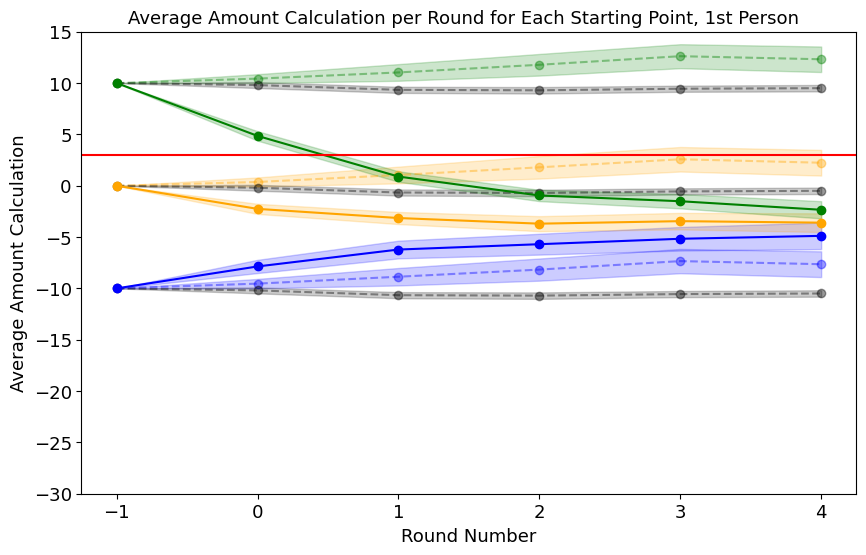

ANOVA Results:
                                        df         sum_sq      mean_sq  \
C(round_number)                       4.0     701.520261   175.380065   
C(starting_point)                     2.0    9693.541176  4846.770588   
C(round_number):C(starting_point)     8.0    3352.903268   419.112908   
Residual                           1515.0  100323.029412    66.219821   

                                           F        PR(>F)  
C(round_number)                     2.648453  3.192800e-02  
C(starting_point)                  73.192142  4.533881e-31  
C(round_number):C(starting_point)   6.329116  4.264995e-08  
Residual                                 NaN           NaN  
There is a statistically significant difference in amount calculation due to the round number.
There is a statistically significant difference in amount calculation due to the starting point.
There is a statistically significant interaction effect between round number and starting point.

Performing Tukey's HSD 

In [1403]:
plot_count_2(choice_filtered_df, ' ')


In [1404]:
def plot_prob_win(game_dicts):
    # Step 1: Group games by starting point and collect variance data
    grouped_prob = {}
    for _, thegame in game_dicts.items():
        starting_point = thegame['starting_point']
        if starting_point not in grouped_prob:
            grouped_prob[starting_point] = []
        
        # Appending a list of dictionaries
        grouped_prob[starting_point].append([thegame['prob_win_1']])

    # Step 2: Compute the average variance and standard error for each starting point group
    plt.figure(figsize=(8, 6))
    x = range(1, 5)
    
    for starting_point, ev in grouped_prob.items():
        master_dictionary:Dict[int,List[float]] = {}
        
        for plist in ev:
            # Each element of plist is a dictionary of type {0:0.122,1:0.55,...}
            for key, value in plist[0].items():
                if key not in master_dictionary.keys():
                    master_dictionary[key] = []
                master_dictionary[key].append(value)
        
        # Converting to a dataframe because it's cool
        starting_point_dataframe:pd.DataFrame = pd.DataFrame(master_dictionary)

        # Doing a lil' stats
        average_of_points:pd.Series = starting_point_dataframe.mean()
        standard_error:pd.Series = starting_point_dataframe.std().div(np.sqrt(len(starting_point_dataframe)))

        index_values:np.ndarray = np.array(average_of_points.index)
        average_values:np.ndarray = average_of_points.values
        standard_error_values:np.ndarray = standard_error.values
        
        # Making approximating the derivative with backwards propagation method (or however you call it)
        # taking f'(x_i) = (f(x_i) - f(x_i-1)) / (x_i - x_i-1)
        average_of_points = pd.DataFrame(average_of_points)
        average_of_points["ShiftForward"] = average_of_points.shift(1)
        average_of_points.fillna(0,inplace=True)

        # We take only the difference since the difference is always 1
        average_of_points[f"{starting_point}_Derivative"] = average_of_points[list(average_of_points.columns)[0]].sub(
            average_of_points["ShiftForward"]
        )
        del average_of_points["ShiftForward"]

        # Plot each starting point group

        if starting_point == -10:
            color = 'blue'
        elif starting_point == 0:
            color = 'orange'
        elif starting_point == 10:
            color = 'green'

        plt.plot(index_values, average_values, '--o', label=f'P_win_1 - Starting Point {starting_point}', color = color)
        plt.fill_between(index_values, average_values - standard_error_values, average_values + standard_error_values, alpha=0.2, color = color)

    plt.xlabel('Round')
    plt.ylabel('P_win_1')
    plt.title('P_win_1 for Different Starting Points, 1st Person')
    plt.xticks(ticks=x) 
    plt.legend()
    plt.show()


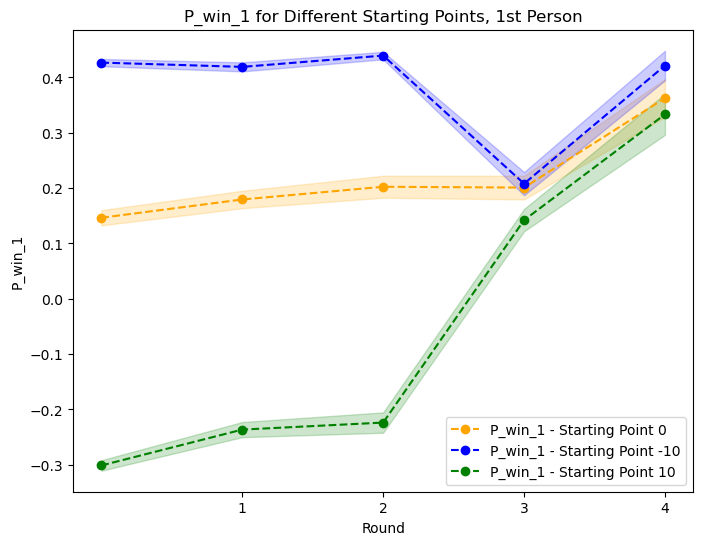

In [1405]:
plot_prob_win(game_dicts)

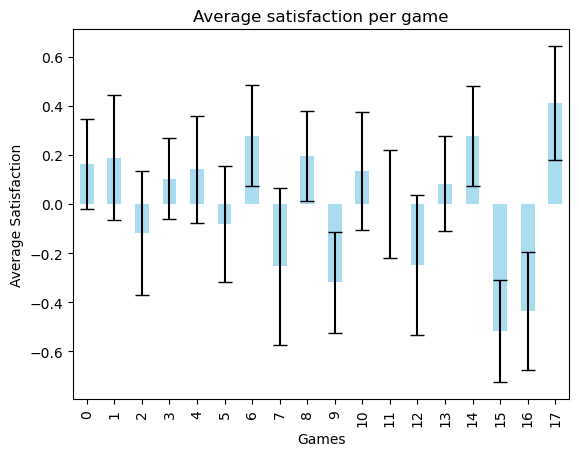

game
0     0.163394
1     0.189458
2    -0.119030
3     0.102922
4     0.142120
5    -0.082312
6     0.278156
7    -0.254119
8     0.196376
9    -0.318628
10    0.133748
11    0.000540
12   -0.249937
13    0.082912
14    0.277926
15   -0.518514
16   -0.435466
17    0.410453
Name: response, dtype: float64

In [1406]:
grouped_overall = sat_filtered_df.groupby(by='game')['response'].mean()
grouped_std = sat_filtered_df.groupby(by='game')['response'].std()/np.sqrt(len(grouped_overall))

ax = grouped_overall.plot(kind='bar', yerr=grouped_std, capsize=5, color=['skyblue'], alpha=0.7)
plt.ylabel('Average Satisfaction')
plt.xlabel('Games')
plt.title('Average satisfaction per game')
plt.show()
grouped_overall


### Satisfaction per outcome grouped by starting point

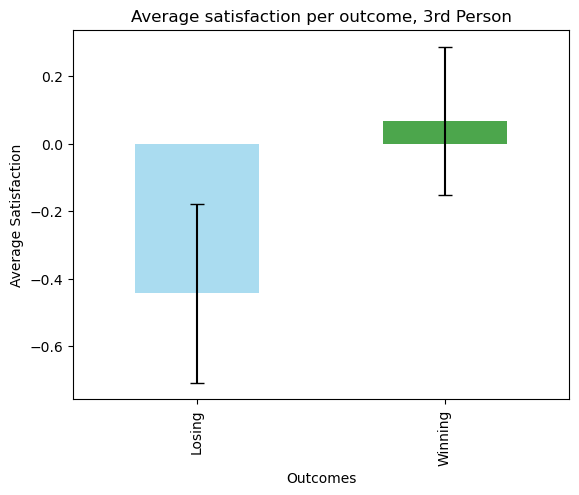

In [1407]:
sat_filtered_df_copy = sat_filtered_df.copy()
sat_filtered_df_copy['outcome'] = sat_filtered_df_copy['outcome'].map({-1: 'Losing', 1: 'Winning'})


grouped_sat_df = sat_filtered_df_copy.groupby(by='outcome')['response'].mean()
grouped_std = sat_filtered_df_copy.groupby(by='outcome')['response'].std()/np.sqrt(len(grouped_overall))




ax = grouped_sat_df.plot(kind='bar', yerr=grouped_std, capsize=5, color=['skyblue', 'green'], alpha=0.7)
plt.ylabel('Average Satisfaction')
plt.xlabel('Outcomes')
plt.title('Average satisfaction per outcome, 3rd Person')
plt.show()

In [1408]:
grouped_sat_df

outcome
Losing    -0.443287
Winning    0.067380
Name: response, dtype: float64

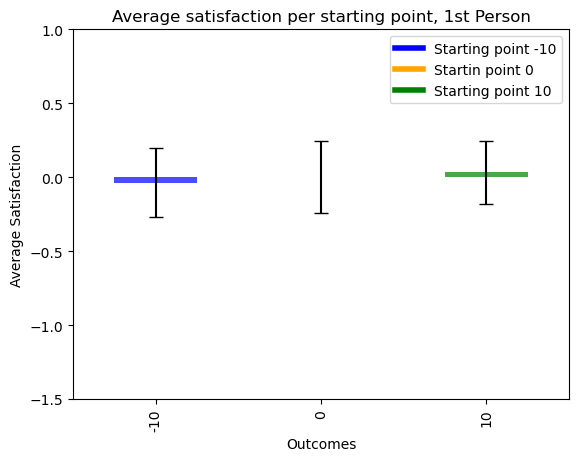

In [1409]:
#include starting point in sat_filtered_df
# sort sat_filtered_df by participant and game to get the same order as in part_starting points
sat_filtered_df.sort_values(by=['participant','game'],inplace=True, ascending=True)

sat_filtered_df['starting_point'] = [part[0] for part in part_starting_points]

sat_filtered_df_copy = sat_filtered_df.copy()
sat_filtered_df_copy['outcome'] = sat_filtered_df_copy['outcome'].map({-1: 'Losing', 1: 'Winning'})

sat_filtered_df_copy

grouped_sat_df = sat_filtered_df_copy.groupby(by=['starting_point'])['response'].mean()
grouped_std = sat_filtered_df_copy.groupby(by=['starting_point'])['response'].std()/np.sqrt(len(grouped_overall))


ax = grouped_sat_df.plot(kind='bar', yerr=grouped_std, capsize=5, color=['blue', 'orange', 'green'], alpha=0.7)
plt.ylabel('Average Satisfaction')
plt.xlabel('Outcomes')
# Create custom legend
custom_legend = [plt.Line2D([0], [0], color='blue', lw=4),
                 plt.Line2D([0], [0], color='orange', lw=4),
                 plt.Line2D([0], [0], color='green', lw=4)]
                 
ax.legend(custom_legend, ['Starting point -10', 'Startin point 0', 'Starting point 10'])
plt.ylim(-1.5, 1)
plt.title('Average satisfaction per starting point, 1st Person')
plt.show()

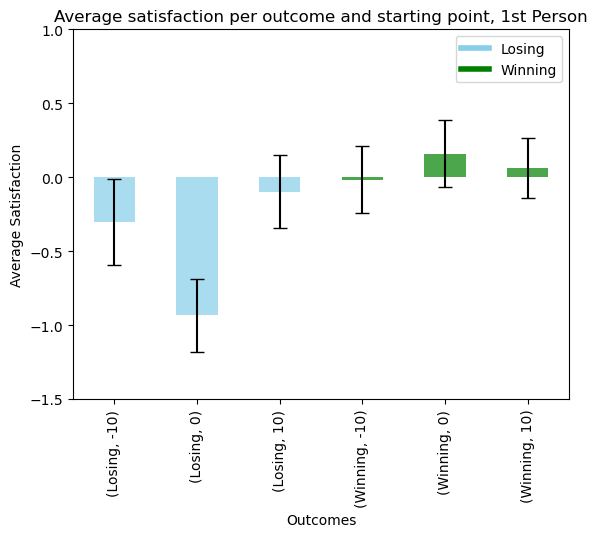

In [1410]:
#include starting point in sat_filtered_df
# sort sat_filtered_df by participant and game to get the same order as in part_starting points
sat_filtered_df.sort_values(by=['participant','game'],inplace=True, ascending=True)

sat_filtered_df['starting_point'] = [part[0] for part in part_starting_points]

sat_filtered_df_copy = sat_filtered_df.copy()
sat_filtered_df_copy['outcome'] = sat_filtered_df_copy['outcome'].map({-1: 'Losing', 1: 'Winning'})

sat_filtered_df_copy

grouped_sat_df = sat_filtered_df_copy.groupby(by=['outcome','starting_point'])['response'].mean()
grouped_std = sat_filtered_df_copy.groupby(by=['outcome','starting_point'])['response'].std()/np.sqrt(len(grouped_overall))

# Create a list of colors based on the outcome
colors = ['skyblue' if outcome == 'Losing' else 'green' for outcome, _ in grouped_sat_df.index]

ax = grouped_sat_df.plot(kind='bar', yerr=grouped_std, capsize=5, color=colors, alpha=0.7)
plt.ylabel('Average Satisfaction')
plt.xlabel('Outcomes')
# Create custom legend
custom_legend = [plt.Line2D([0], [0], color='skyblue', lw=4),
                 plt.Line2D([0], [0], color='green', lw=4)]
                 
ax.legend(custom_legend, ['Losing', 'Winning'])
plt.ylim(-1.5, 1)
plt.title('Average satisfaction per outcome and starting point, 1st Person')
plt.show()

### Linear Models

In [1411]:
average_min_EV_count_minus_10

array([-16.55555556, -23.14166667, -29.53611111, -36.01944444,
       -42.24722222])

In [1412]:
#Compute linear model for count per starting point

participant_models = {}
participant_param = {}

# Group data by participant
participants = choice_filtered_df['participant'].unique()

for participant in participants:
    # Filter data for the current participant
    df_participant = choice_filtered_df[choice_filtered_df['participant'] == participant]
    
    # Group by round_number and starting_point, and calculate the mean and standard error of amount_calculation
    grouped_mean = df_participant.groupby(['round_number', 'starting_point'])['amount_calculation'].mean().unstack()
    grouped_std = df_participant.groupby(['round_number', 'starting_point'])['amount_calculation'].std().unstack()
    n = df_participant.groupby(['round_number', 'starting_point'])['amount_calculation'].count().unstack()
    
    # Prepare the data for linear modeling
    for sp in grouped_mean.columns:
        X = grouped_mean.index.values.reshape(-1, 1)  # Round numbers as the independent variable
        y = grouped_mean[sp].values  # Mean amount calculation as the dependent variable

        # Add a constant to the independent variables (for the intercept)
        X_const = sm.add_constant(X)
        
        # Create and fit the linear regression model
        model = sm.OLS(y, X_const).fit()


        model_param = {
        "params": model.params.tolist()}
        
        # Save the model
        if participant not in participant_models:
            participant_models[participant] = {}
            participant_param[participant] = {}

        participant_models[participant][f'Starting Point {sp}'] = model
        participant_param[participant][f'Starting Point {sp}'] = model_param



       

In [1413]:
#Save slopes per starting point

starting_point_minus_10_slopes = []
starting_point_0_slopes = []
starting_point_10_slopes = []

for participant in participant_param:
    starting_point_minus_10_slope = participant_param[participant]['Starting Point -10']['params'][1]
    starting_point_0_slope = participant_param[participant]['Starting Point 0']['params'][1]
    starting_point_10_slope = participant_param[participant]['Starting Point 10']['params'][1]

    starting_point_minus_10_slopes.append(starting_point_minus_10_slope)
    starting_point_0_slopes.append(starting_point_0_slope)
    starting_point_10_slopes.append(starting_point_10_slope)


#save slopes from 3rd person to compare with model of 1st person

with open('starting_point_minus_10_slopes_1st.json', 'w') as f:
    json.dump(starting_point_minus_10_slopes, f)

with open('starting_point_0_slopes_1st.json', 'w') as f:
    json.dump(starting_point_0_slopes, f)

with open('starting_point_10_slopes_1st.json', 'w') as f:
    json.dump(starting_point_10_slopes, f)

In [1414]:
#Compare models R^2 and BIC

# Initialize dictionaries to store BIC and R-squared values for each starting point
bic_per_starting_point = {}
r2_per_starting_point = {}

# Loop through participants
for participant_models in participant_models.values():
    # Loop through each starting point for the current participant
    for starting_point, model in participant_models.items():
        # Retrieve BIC and R-squared values for the current model
        bic_value = model.bic
        r2_value = model.rsquared
        
        # Update dictionaries with BIC and R-squared values for the current starting point
        if starting_point not in bic_per_starting_point:
            bic_per_starting_point[starting_point] = []
            r2_per_starting_point[starting_point] = []
        
        bic_per_starting_point[starting_point].append(bic_value)
        r2_per_starting_point[starting_point].append(r2_value)

# Compute average BIC and R-squared values per starting point across all participants
average_bic_per_starting_point = {starting_point: np.mean(bic_values) for starting_point, bic_values in bic_per_starting_point.items()}
average_r2_per_starting_point = {starting_point: np.mean(r2_values) for starting_point, r2_values in r2_per_starting_point.items()}

# Print the results
for starting_point, avg_bic in average_bic_per_starting_point.items():
    avg_r2 = average_r2_per_starting_point[starting_point]
    print(f"Starting Point: {starting_point}")
    print(f"Average BIC for Round: {avg_bic}")
    print(f"Average R-squared Round: {avg_r2}\n")


Starting Point: Starting Point -10
Average BIC for Round: 17.675333646448294
Average R-squared Round: 0.7636586319407987

Starting Point: Starting Point 0
Average BIC for Round: 14.150886530236058
Average R-squared Round: 0.655673399969613

Starting Point: Starting Point 10
Average BIC for Round: 17.82513604760442
Average R-squared Round: 0.6484676326972144



In [1415]:
#Compute linear model for count per starting point, Quadratic round version

participant_models_quadr = {}
participant_param_quadr= {}

# Group data by participant
participants = choice_filtered_df['participant'].unique()

for participant in participants:
    # Filter data for the current participant
    df_participant = choice_filtered_df[choice_filtered_df['participant'] == participant]
    
    # Group by round_number and starting_point, and calculate the mean and standard error of amount_calculation
    grouped_mean = df_participant.groupby(['round_number', 'starting_point'])['amount_calculation'].mean().unstack()
    grouped_std = df_participant.groupby(['round_number', 'starting_point'])['amount_calculation'].std().unstack()
    n = df_participant.groupby(['round_number', 'starting_point'])['amount_calculation'].count().unstack()
    
    # Prepare the data for linear modeling
    for sp in grouped_mean.columns:
        X = grouped_mean.index.values.reshape(-1, 1)  # Round numbers as the independent variable
        y = grouped_mean[sp].values  # Mean amount calculation as the dependent variable
        

        # Create quadratic terms
        X_quad =  X**2


        # Add a constant to the independent variables (for the intercept)
        X_const = sm.add_constant(X_quad)
        
        # Create and fit the linear regression model
        model = sm.OLS(y, X_const).fit()


        model_param = {
        "params": model.params.tolist()}
        
        # Save the model
        if participant not in participant_models_quadr:
            participant_models_quadr[participant] = {}
            participant_param_quadr[participant] = {}

        participant_models_quadr[participant][f'Starting Point {sp}'] = model
        participant_param_quadr[participant][f'Starting Point {sp}'] = model_param



       

In [1416]:
#Save slopes per starting point

starting_point_minus_10_slopes_quadr = []
starting_point_0_slopes_quadr = []
starting_point_10_slopes_quadr = []

for participant in participant_param:
    starting_point_minus_10_slope = participant_param[participant]['Starting Point -10']['params'][1]
    starting_point_0_slope = participant_param[participant]['Starting Point 0']['params'][1]
    starting_point_10_slope = participant_param[participant]['Starting Point 10']['params'][1]

    starting_point_minus_10_slopes.append(starting_point_minus_10_slope)
    starting_point_0_slopes.append(starting_point_0_slope)
    starting_point_10_slopes.append(starting_point_10_slope)


#save slopes from 3rd person to compare with model of 1st person

with open('starting_point_minus_10_slopes_1st_quadr.json', 'w') as f:
    json.dump(starting_point_minus_10_slopes_quadr, f)

with open('starting_point_0_slopes_1st_quadr.json', 'w') as f:
    json.dump(starting_point_0_slopes_quadr, f)

with open('starting_point_10_slopes_1st_quadr.json', 'w') as f:
    json.dump(starting_point_10_slopes_quadr, f)


In [1417]:
# Initialize dictionaries to store BIC and R-squared values for each starting point
bic_per_starting_point_quadr = {}
r2_per_starting_point_quadr = {}

# Loop through participants
for participant_models in participant_models_quadr.values():
    # Loop through each starting point for the current participant
    for starting_point, model in participant_models.items():
        # Retrieve BIC and R-squared values for the current model
        bic_value = model.bic
        r2_value = model.rsquared
        
        # Update dictionaries with BIC and R-squared values for the current starting point
        if starting_point not in bic_per_starting_point_quadr:
            bic_per_starting_point_quadr[starting_point] = []
            r2_per_starting_point_quadr[starting_point] = []
        
        bic_per_starting_point_quadr[starting_point].append(bic_value)
        r2_per_starting_point_quadr[starting_point].append(r2_value)

# Compute average BIC and R-squared values per starting point across all participants
average_bic_per_starting_point_quadr = {starting_point: np.mean(bic_values) for starting_point, bic_values in bic_per_starting_point_quadr.items()}
average_r2_per_starting_point_quadr = {starting_point: np.mean(r2_values) for starting_point, r2_values in r2_per_starting_point_quadr.items()}

# Print the results
for starting_point, avg_bic in average_bic_per_starting_point_quadr.items():
    avg_r2 = average_r2_per_starting_point_quadr[starting_point]
    print(f"Starting Point: {starting_point}")
    print(f"Average BIC for Quadratic Round: {avg_bic}")
    print(f"Average R-squared for Quadratic Round: {avg_r2}\n")

Starting Point: Starting Point -10
Average BIC for Quadratic Round: 20.4666225034785
Average R-squared for Quadratic Round: 0.6437478413210617

Starting Point: Starting Point 0
Average BIC for Quadratic Round: 15.906645550336082
Average R-squared for Quadratic Round: 0.5914804289147098

Starting Point: Starting Point 10
Average BIC for Quadratic Round: 21.786372339458957
Average R-squared for Quadratic Round: 0.47906546907456105



In [1418]:
#Include EV and Var per round in choice_filtered_df

# Function to calculate EV
def calculate_ev(row):
    return (row['card_1'] + row['card_2']) / 2

# Function to calculate Variance
def calculate_variance(row):
    mean = (row['card_1'] + row['card_2']) / 2
    variance = ((row['card_1'] - mean) ** 2 + (row['card_2'] - mean) ** 2) / 2
    return variance

# Apply the functions to the DataFrame
choice_filtered_df['EV'] = choice_filtered_df.apply(calculate_ev, axis=1)
choice_filtered_df['Variance'] = choice_filtered_df.apply(calculate_variance, axis=1)

choice_filtered_df

,rt,response,trial,game_index,round_number,card_1,card_2,card_result,starting_point,amount_calculation,click_catch,participant,success_rate,game_outcome,EV,Variance
0,5369,2,12,0,0,-2,-10,-2,0,-2,3,Participant1,85.555556,1,-6.0,16.00
1,9150,3,12,0,1,-2,1,1,0,-1,1,Participant1,85.555556,1,-0.5,2.25
2,4918,3,12,0,2,1,0,1,0,0,0,Participant1,85.555556,1,0.5,0.25
3,3249,3,12,0,3,1,0,1,0,1,0,Participant1,85.555556,1,0.5,0.25
4,3281,2,12,0,4,-2,-3,-3,0,-2,3,Participant1,85.555556,1,-2.5,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1525,3060,1,15,17,0,10,5,10,-10,0,2,Participant9,76.666667,1,7.5,6.25
1526,1804,0,15,17,1,3,8,8,-10,8,2,Participant9,76.666667,1,5.5,6.25
1527,1095,1,15,17,2,-10,-3,-3,-10,5,3,Participant9,76.666667,1,-6.5,12.25
1528,2139,3,15,17,3,2,-3,2,-10,7,0,Participant9,76.666667,1,-0.5,6.25


In [1419]:
#Compute linear model for EV per starting point

participant_models_EV = {}
participant_param_EV = {}

# Group data by participant
participants = choice_filtered_df['participant'].unique()

for participant in participants:
    # Filter data for the current participant
    df_participant = choice_filtered_df[choice_filtered_df['participant'] == participant]
    
    # Group by round_number and starting_point, and calculate the mean and standard error of amount_calculation
    grouped_mean = df_participant.groupby(['round_number', 'starting_point'])['EV'].mean().unstack()
    grouped_std = df_participant.groupby(['round_number', 'starting_point'])['EV'].std().unstack()
    n = df_participant.groupby(['round_number', 'starting_point'])['EV'].count().unstack()
    
    # Prepare the data for linear modeling
    for sp in grouped_mean.columns:
        X = grouped_mean.index.values.reshape(-1, 1)  # Round numbers as the independent variable
        y = grouped_mean[sp].values  # Mean amount calculation as the dependent variable

        # Add a constant to the independent variables (for the intercept)
        X_const = sm.add_constant(X)
        
        # Create and fit the linear regression model
        model_EV = sm.OLS(y, X_const).fit()


        model_param_EV = {
        "params": model_EV.params.tolist()}
        
        # Save the model
        if participant not in participant_models_EV:
            participant_models_EV[participant] = {}
            participant_param_EV[participant] = {}

        participant_models_EV[participant][f'Starting Point {sp}'] = model_EV
        participant_param_EV[participant][f'Starting Point {sp}'] = model_param_EV



       

In [1420]:
#Save slopes per starting point

starting_point_minus_10_slopes_EV = []
starting_point_0_slopes_EV = []
starting_point_10_slopes_EV = []

for participant in participant_param_EV:
    starting_point_minus_10_slope = participant_param_EV[participant]['Starting Point -10']['params'][1]
    starting_point_0_slope = participant_param_EV[participant]['Starting Point 0']['params'][1]
    starting_point_10_slope = participant_param_EV[participant]['Starting Point 10']['params'][1]

    starting_point_minus_10_slopes_EV.append(starting_point_minus_10_slope)
    starting_point_0_slopes_EV.append(starting_point_0_slope)
    starting_point_10_slopes_EV.append(starting_point_10_slope)


#save slopes from 3rd person to compare with model of 1st person

with open('starting_point_minus_10_slopes_1st_EV.json', 'w') as f:
    json.dump(starting_point_minus_10_slopes_EV, f)

with open('starting_point_0_slopes_1st_EV.json', 'w') as f:
    json.dump(starting_point_0_slopes_EV, f)

with open('starting_point_10_slopes_1st_EV.json', 'w') as f:
    json.dump(starting_point_10_slopes_EV, f)

In [1421]:
# Compute linear model for Var per starting point

participant_models_Var = {}
participant_param_Var = {}

# Group data by participant
participants = choice_filtered_df['participant'].unique()

for participant in participants:
    # Filter data for the current participant
    df_participant = choice_filtered_df[choice_filtered_df['participant'] == participant]
    
    # Group by round_number and starting_point, and calculate the mean and standard error of amount_calculation
    grouped_mean = df_participant.groupby(['round_number', 'starting_point'])['Variance'].mean().unstack()
    grouped_std = df_participant.groupby(['round_number', 'starting_point'])['Variance'].std().unstack()
    n = df_participant.groupby(['round_number', 'starting_point'])['Variance'].count().unstack()
    
    # Prepare the data for linear modeling
    for sp in grouped_mean.columns:
        X = grouped_mean.index.values.reshape(-1, 1)  # Round numbers as the independent variable
        y = grouped_mean[sp].values  # Mean amount calculation as the dependent variable

        # Add a constant to the independent variables (for the intercept)
        X_const = sm.add_constant(X)
        
        # Create and fit the linear regression model
        model_Var = sm.OLS(y, X_const).fit()

        model_param_Var = {
            "params": model_Var.params.tolist()
        }
        
        # Save the model
        if participant not in participant_models_Var:
            participant_models_Var[participant] = {}
            participant_param_Var[participant] = {}  # Initialize the dictionary here

        participant_models_Var[participant][f'Starting Point {sp}'] = model_Var
        participant_param_Var[participant][f'Starting Point {sp}'] = model_param_Var

In [1422]:
#Save slopes per starting point

starting_point_minus_10_slopes_Var = []
starting_point_0_slopes_Var = []
starting_point_10_slopes_Var = []

for participant in participant_param_Var:
    starting_point_minus_10_slope = participant_param_Var[participant]['Starting Point -10']['params'][1]
    starting_point_0_slope = participant_param_Var[participant]['Starting Point 0']['params'][1]
    starting_point_10_slope = participant_param_Var[participant]['Starting Point 10']['params'][1]

    starting_point_minus_10_slopes_Var.append(starting_point_minus_10_slope)
    starting_point_0_slopes_Var.append(starting_point_0_slope)
    starting_point_10_slopes_Var.append(starting_point_10_slope)


#save slopes from 3rd person to compare with model of 1st person

with open('starting_point_minus_10_slopes_1st_var.json', 'w') as f:
    json.dump(starting_point_minus_10_slopes_Var, f)

with open('starting_point_0_slopes_1st_var.json', 'w') as f:
    json.dump(starting_point_0_slopes_Var, f)

with open('starting_point_10_slopes_1st_var.json', 'w') as f:
    json.dump(starting_point_10_slopes_Var, f)

In [1423]:
#Compute satisfaction as a function of suspense sum

participants_dfs_susp = {}
participants_to_exclude = ["Participant10"]

for participant, game in game_dicts:
    if participant in participants_to_exclude:
        continue
    df = pd.DataFrame ({
        'Outcome' : game_dicts[(participant,game)]['iswin'], 
        'Starting point' : game_dicts[(participant,game)]['starting_point'],
        'Suspense': game_dicts[(participant,game)]['suscpr']['L1']

    })
    total_suspense = df["Suspense"].sum()
    game_df= pd.DataFrame({
        "Game":[game],
        "Suspense":[total_suspense],
    })
    if participant not in participants_dfs_susp:
        participants_dfs_susp[participant] = game_df
    else:
        participants_dfs_susp[participant] = pd.concat([participants_dfs_susp[participant] ,game_df])


In [1424]:
# Ensure the starting points are included in the filtered DataFrame
sat_filtered_df['starting_point'] = [part[0] for part in part_starting_points]

# Sort the DataFrame by participant and game to align the order with part_starting_points
sat_filtered_df.sort_values(by=['participant', 'game'], inplace=True)

# Create a copy of the DataFrame and map the 'outcome' values to 'Losing' and 'Winning'
sat_filtered_df = sat_filtered_df.copy()
sat_filtered_df['outcome'] = sat_filtered_df['outcome'].map({-1: 'Losing', 1: 'Winning'})

#remove participant 10 as all its satisfaction ratings are absent

sat_filtered_df = sat_filtered_df[sat_filtered_df['participant'] != 'Participant10']


In [1425]:
# Get unique participant IDs
participants = sat_filtered_df['participant'].unique()

# Create a dictionary to store DataFrames for each participant
participant_dfs_sat = {}

# Iterate over each participant
for participant in participants:
    # Filter data for the current participant
    participant_df = sat_filtered_df[sat_filtered_df['participant'] == participant].copy()
    
    # Store the DataFrame for the current participant in the dictionary
    participant_dfs_sat[participant] = participant_df

In [1426]:


# Create a dictionary to store DataFrames for each participant
participant_models = {}
participant_param = {}

# Lists to store models and parameters for each starting point category
model = []
param = []

# First compute 17 different models (1 per participant)
for participant_sat, participant_susp in zip(participant_dfs_sat, participants_dfs_susp):
    # Extract satisfaction per game
    sat = participant_dfs_sat[participant_sat]['response'].reset_index(drop=True)
    susp_sum = participants_dfs_susp[participant_susp]
    if not susp_sum.index.name == "Game":
        susp_sum.set_index("Game",inplace=True)

    # Merging the data to one dataframe
    model_df =pd.merge(
        sat,susp_sum,left_index=True,right_index=True
    )
    model_df.rename(columns={
        "Suspense":"suspense_sum",
        "response":"satisfaction",
    },inplace=True)


    # Define the dependent variable
    y = model_df['satisfaction']

    # Define the independent variables (including the dummy variables for starting_point)
    X = model_df['suspense_sum']

    # Add a constant to the independent variables (for the intercept)
    X_const = sm.add_constant(X)

    # Create and fit the linear regression model
    model_sat_part = sm.OLS(y, X_const).fit()

    # Save model results to dictionaries
    model_sat = {
        "params": model_sat_part.params.tolist(),
        "llf": model_sat_part.llf,
        "aic": model_sat_part.aic,
        "bic": model_sat_part.bic,
        "std_err": model_sat_part.bse.tolist()
    }

    participant_models[participant_sat] = model_sat_part
    participant_param[participant_sat] = model_sat

    # Save models and parameters based on starting point categories
    #if 'starting_point_10' in X.columns:
        #model_sp_10.append(model_sat_part)
        #param_sp_10.append(model_sat)



In [1427]:
#Save slopes for satisfaction explained by suspense sum

all_slopes = []
for participant in participant_param:

    satisfaction = participant_param[participant]['params'][1]
    all_slopes.append(satisfaction)




#save slopes from 3rd person to compare with model of 1st person

with open('satisfaction_slopes_cond_2_1st.json', 'w') as f:
    json.dump(all_slopes, f)

    

In [1428]:
### Creates the data_per_participant dictionary with keys as the participant and the keys of the sub dictionary as the starting point

starting_points = [-10,0,10]

# Getting the unique participants
unique_participants = participant_dfs_sat.keys()

data_per_participant = {}

# Initialising a dictionary that stores data depending on the starting point
for participant in unique_participants:
    data_per_participant[participant] = {}

for starting_point in starting_points:
    for participant in unique_participants:
        data = participant_dfs_sat[participant]
        # copy the data to a data frame
        inscope_data = data.loc[data["starting_point"] == starting_point].copy()

        # taking the suspense data and merging onto the inscope data
        participant_suspense = participants_dfs_susp[participant].copy()
        participant_suspense.reset_index(inplace=True)
        participant_suspense.rename(columns={"Game":"game"},inplace=True)

        # merging the data back together
        inscope_data = pd.merge(inscope_data,participant_suspense,how="left",on='game')

        starting_point_dict = data_per_participant[participant]
        if starting_point not in starting_point_dict.keys():
            starting_point_dict[starting_point] = pd.DataFrame()
        
        # Storing the data
        starting_point_dict[starting_point] = pd.concat([
            starting_point_dict[starting_point] , inscope_data
        ])



In [1429]:
starting_points = [-10,0,10]

linear_model_param = {}
linear_models = {}
for starting_point in starting_points:
    linear_model_param[starting_point] = {}
    linear_models[starting_point] = {}

for participant in data_per_participant.keys():
    for starting_point in starting_points:
        inscope_data = data_per_participant[participant][starting_point].copy()

        inscope_data.rename(columns={
            "Suspense":"suspense_sum",
            "response":"satisfaction",
            },inplace=True)


        # Define the dependent variable
        y = inscope_data['satisfaction']

        # Define the independent variables (including the dummy variables for starting_point)
        X = inscope_data['suspense_sum']

        # Add a constant to the independent variables (for the intercept)
        X_const = sm.add_constant(X)
        
        # Create and fit the linear regression model
        model_sat_part = sm.OLS(y, X_const).fit()

        # Save model results to dictionaries
        model_sat = {
            "params": model_sat_part.params.tolist(),
            "llf": model_sat_part.llf,
            "aic": model_sat_part.aic,
            "bic": model_sat_part.bic,
            "std_err": model_sat_part.bse.tolist()
        }

        # Storing the data into a dictionary
        linear_model_param[starting_point][participant] = model_sat
        linear_models[starting_point][participant] = model_sat_part


In [1430]:

#save slopes from 3rd person to compare with model of 1st person

with open('satisfaction_slopes_cond_2_minus_10_1st.json', 'w') as f:
    json.dump(linear_model_param[-10], f)

with open('satisfaction_slopes_cond_2_0_1st.json', 'w') as f:
    json.dump(linear_model_param[0], f)

with open('satisfaction_slopes_cond_2_plus_10_1st.json', 'w') as f:
    json.dump(linear_model_param[10], f)
